In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


from scipy.stats import skew

from imblearn.over_sampling import SMOTE 
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , roc_auc_score, classification_report, roc_curve

In [3]:
import pandas as pd 
path="../data/ola_driver.csv"
df=pd.read_csv(r"{path}".format(path=path))

## Define Problem Statement and perform Exploratory Data Analysis

### Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

### Column Profiling:

- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

#### Observations in Data

In [4]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [4]:
df.tail()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
19099,19099,08/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3
19100,19100,09/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3
19101,19101,10/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2
19102,19102,11/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2
19103,19103,12/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,411480,2


In [5]:
# dropping Unnamed: 0 col 
df.drop(columns="Unnamed: 0",inplace=True)

In [6]:
# descriptive summary 
df.describe()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


- drivers have varied ages from 21 (lowest) to 58 (highest) years of age
- there are 59% male drivers and 41% female drivers 

In [7]:
# checking datatyps 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [8]:
# lets check data for a given driverID 
df[df['Driver_ID'] == 18]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
63,01/01/19,18,27.0,1.0,C17,1,31631,01/09/19,NaN,1,1,0,1
64,02/01/19,18,27.0,1.0,C17,1,31631,01/09/19,NaN,1,1,0,1
65,03/01/19,18,27.0,1.0,C17,1,31631,01/09/19,NaN,1,1,0,1
66,04/01/19,18,27.0,1.0,C17,1,31631,01/09/19,NaN,1,1,0,1
67,05/01/19,18,27.0,1.0,C17,1,31631,01/09/19,30/04/19,1,1,0,1


In [9]:
val = df[['Driver_ID']].sample()
did = val.iloc[0,0]
df[df['Driver_ID'] == did]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
17055,01/01/19,2517,31.0,1.0,C26,1,83236,31/05/15,NaN,2,4,2485180,3
17056,02/01/19,2517,31.0,1.0,C26,1,83236,31/05/15,NaN,2,4,6530520,3
17057,03/01/19,2517,31.0,1.0,C26,1,83236,31/05/15,NaN,2,4,1962720,3
17058,04/01/19,2517,32.0,1.0,C26,1,83236,31/05/15,NaN,2,4,338250,2
17059,05/01/19,2517,32.0,1.0,C26,1,83236,31/05/15,NaN,2,4,203910,2
17060,06/01/19,2517,32.0,1.0,C26,1,83236,31/05/15,NaN,2,4,226640,2
17061,07/01/19,2517,32.0,1.0,C26,1,83236,31/05/15,NaN,2,4,370590,3
17062,08/01/19,2517,32.0,1.0,C26,1,83236,31/05/15,NaN,2,4,648400,3
17063,09/01/19,2517,32.0,1.0,C26,1,83236,31/05/15,NaN,2,4,1965380,3
17064,10/01/19,2517,32.0,1.0,C26,1,83236,31/05/15,NaN,2,4,577560,1


In [10]:
# checking missing data 
df.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [11]:
# # imputing data 
# imputer = KNNImputer() 

In [12]:
# converting objects to datetime format 
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'],errors='coerce')
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'],errors='coerce')

In [13]:
df[df['Driver_ID'] == 18]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
63,01/01/19,18,27.0,1.0,C17,1,31631,2019-01-09,NaT,1,1,0,1
64,02/01/19,18,27.0,1.0,C17,1,31631,2019-01-09,NaT,1,1,0,1
65,03/01/19,18,27.0,1.0,C17,1,31631,2019-01-09,NaT,1,1,0,1
66,04/01/19,18,27.0,1.0,C17,1,31631,2019-01-09,NaT,1,1,0,1
67,05/01/19,18,27.0,1.0,C17,1,31631,2019-01-09,2019-04-30,1,1,0,1


In [14]:
# groupping over driverid to have our data behaviour consistent 
def check(x):   
    val = x.unique()
    return val[-1]

groups = df.groupby("Driver_ID")
# agg_dict = {
#     "MMM-YY" : "count",
#     "Age" : 'first', 
#     "Gender" : "first",
#     "City" : 'first',
#     "Education_Level" : 'first',
#     "Income" : 'first',
#     "Dateofjoining" : 'first',
#     "LastWorkingDate" : 'last',
#     "Joining Designation" : 'first',
#     "Grade" : 'first',
#     "Total Business Value" : "sum" ,
#     "Quarterly Rating" : 'mean'
# }

dfg = groups.agg(
    total_months=("MMM-YY" ,"count"),
    age=('Age','first'),
    gender=('Gender',"first"),
    city=("City",'first'),
    education=("Education_Level" , "first"),
    income=("Income",'last'),
    DOJ= ("Dateofjoining" , 'first'),
    LWD= ("LastWorkingDate" , check) ,
    joining_designation=("Joining Designation" , 'first'),
    grade=("Grade" , 'first'),
    total_business_val=("Total Business Value" , "sum"),
    quarterly_rating=("Quarterly Rating" , 'mean')
).reset_index()

In [15]:
print(f"Total number of unique driverID : {groups.ngroups}")

Total number of unique driverID : 2381


In [16]:
dfg.head()

,Driver_ID,total_months,age,gender,city,education,income,DOJ,LWD,joining_designation,grade,total_business_val,quarterly_rating
0,1,3,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2.0
1,2,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1.0
2,4,5,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,350000,1.0
3,5,3,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,120360,1.0
4,6,5,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,1265000,1.6


In [17]:
dfg.isna().sum()

Driver_ID                0
total_months             0
age                      0
gender                   0
city                     0
education                0
income                   0
DOJ                      0
LWD                    765
joining_designation      0
grade                    0
total_business_val       0
quarterly_rating         0
dtype: int64

In [18]:
# creating the target 
dfg['Churn']=dfg['LWD'].fillna(0).apply(lambda x : 1 if x!=0 else 0)
dfg.drop(columns='LWD',inplace=True)

In [19]:
dfg.head()

,Driver_ID,total_months,age,gender,city,education,income,DOJ,joining_designation,grade,total_business_val,quarterly_rating,Churn
0,1,3,28.0,0.0,C23,2,57387,2018-12-24,1,1,1715580,2.0,1
1,2,2,31.0,0.0,C7,2,67016,2020-11-06,2,2,0,1.0,0
2,4,5,43.0,0.0,C13,2,65603,2019-12-07,2,2,350000,1.0,1
3,5,3,29.0,0.0,C9,0,46368,2019-01-09,1,1,120360,1.0,1
4,6,5,31.0,1.0,C11,1,78728,2020-07-31,3,3,1265000,1.6,0


In [20]:
dfg['gender'].value_counts(normalize=True)

0.0    0.589668
1.0    0.410332
Name: gender, dtype: float64

In [21]:
# target distribution 
dfg['Churn'].value_counts(normalize=True)

1    0.678706
0    0.321294
Name: Churn, dtype: float64

In [22]:
dfg.isna().sum()

Driver_ID              0
total_months           0
age                    0
gender                 0
city                   0
education              0
income                 0
DOJ                    0
joining_designation    0
grade                  0
total_business_val     0
quarterly_rating       0
Churn                  0
dtype: int64

#### Univariate Analysis

In [23]:
continuous_cols = dfg.select_dtypes(exclude='object').columns
categorical_cols = dfg.select_dtypes(include='object').columns

In [24]:
# plotting histogram for contiuous values 
continuous_cols

Index(['Driver_ID', 'total_months', 'age', 'gender', 'education', 'income',
       'DOJ', 'joining_designation', 'grade', 'total_business_val',
       'quarterly_rating', 'Churn'],
      dtype='object')

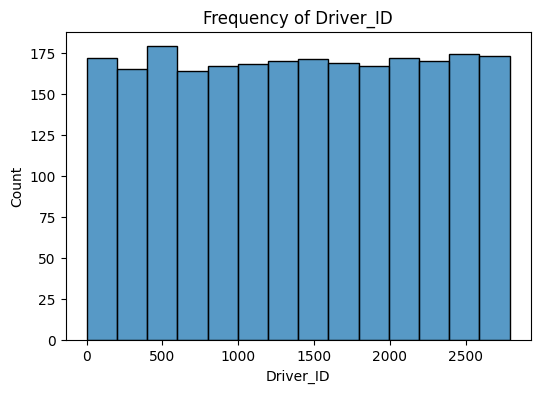

In [25]:
col = "Driver_ID"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data is uniformly distributed

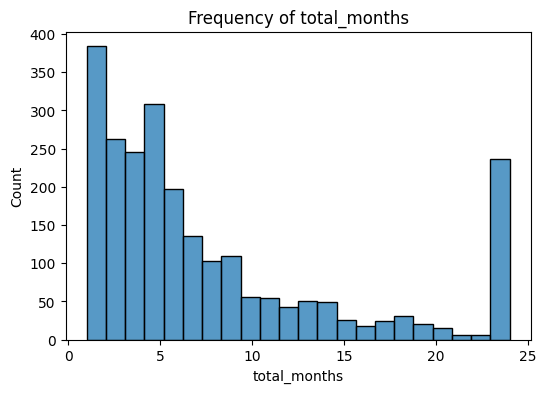

In [26]:
col = "total_months"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data is right skewed, most of the drivers have records for 0-5 months [i.e most of the driver have worked 0-5 months]

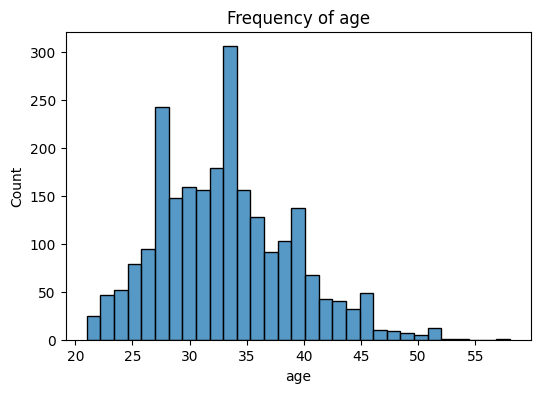

In [27]:
col = "age"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data is almost normally distributed, with most age between 33-35

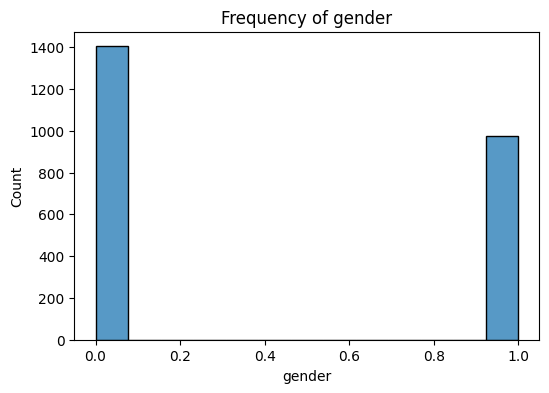

In [28]:
col = "gender"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> there are more male (0) than femal (1) drivers in the data

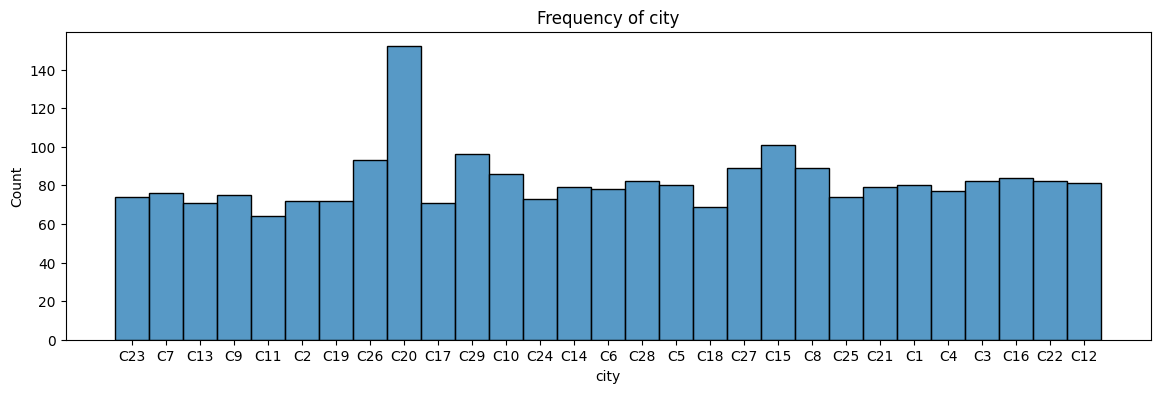

In [29]:
col = "city"
plt.figure(figsize=(14,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data is uniformly distributed with city with citycode `c20` having the maximum frequency in the data 

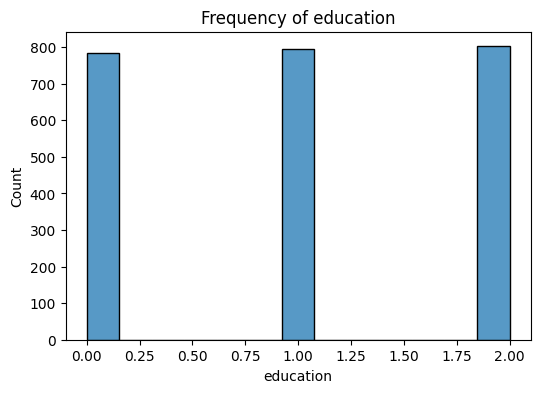

In [30]:
col = "education"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> education data is uniformly distributed ( we have diverse drivers with different educational backgraounds)

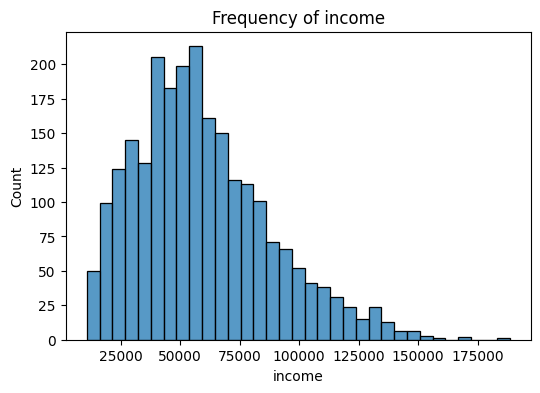

In [31]:
col = "income"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data is having a right skewness with most drivers generating income between 50,000 - 70,000

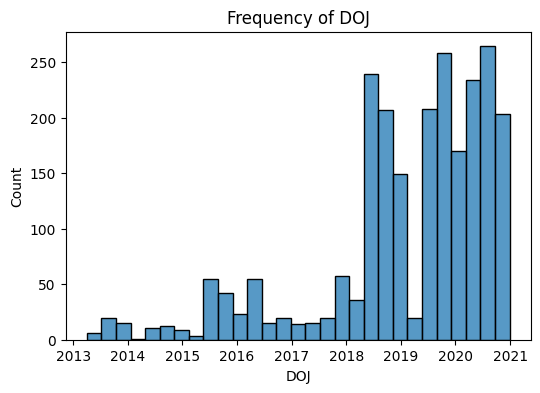

In [32]:
col = "DOJ"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> DOJ is having left skewness; most of the drivers in the company have joined in recent years [between 2018 - 2021]

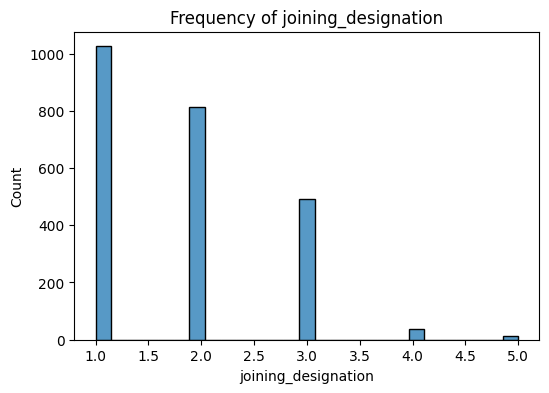

In [33]:
col = "joining_designation"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data have a right skewness; most of the drivers when they start working their joining degisnation is 1.0

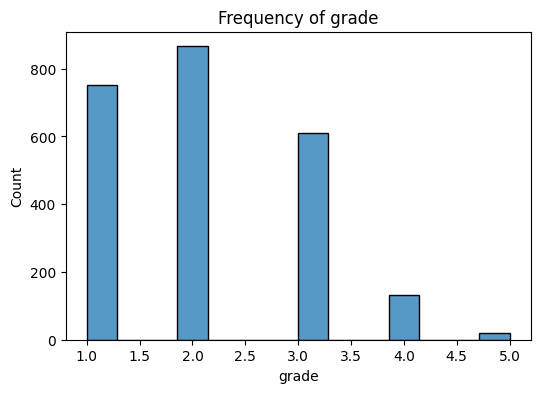

In [34]:
col = "grade"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data have right skewness with most drivers having grade of 2.0 

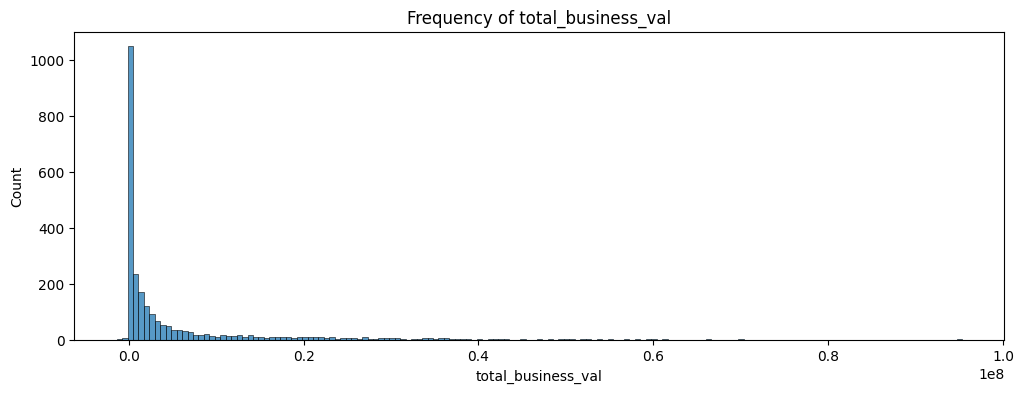

In [35]:
col = "total_business_val"
plt.figure(figsize=(12,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> income data is extremely right skewed

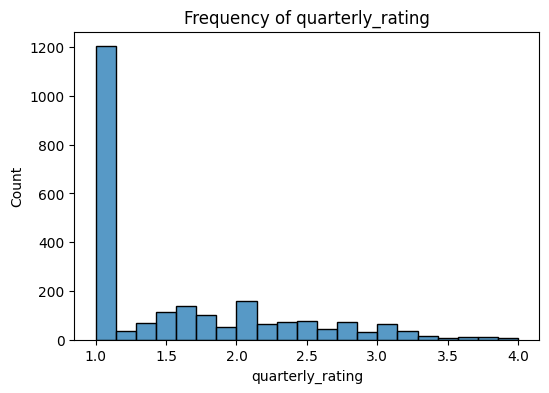

In [36]:
col = "quarterly_rating"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data is having right skewness, with most drivering receiving a quarter rating of 1.0

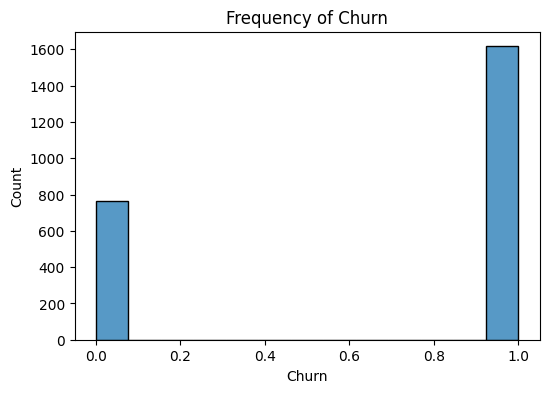

In [37]:
col = "Churn"
plt.figure(figsize=(6,4))
sns.histplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> data shows that most of the drivers have churned as compared to non-churn drivers.

In [38]:
# plotting histogram for contiuous values 
categorical_cols

Index(['city'], dtype='object')

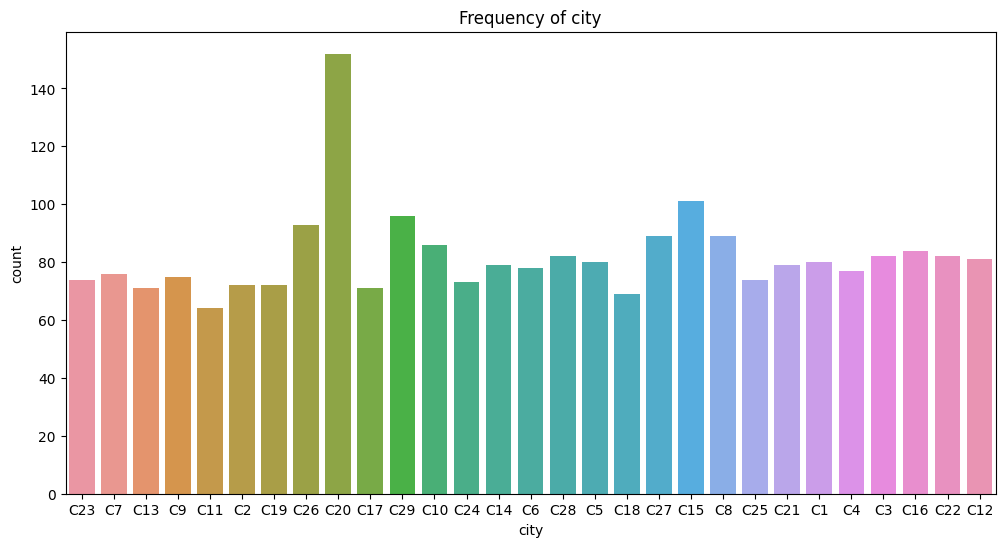

In [39]:
col = "city"
plt.figure(figsize=(12,6))
sns.countplot(data=dfg,x=col)
plt.title(f"Frequency of {col}")
plt.show()

> city with citycode : `C20` has the highest requency in the data, this shows that this city could be a hotstop for the ride-sharing comapny

#### Bivariate Analysis

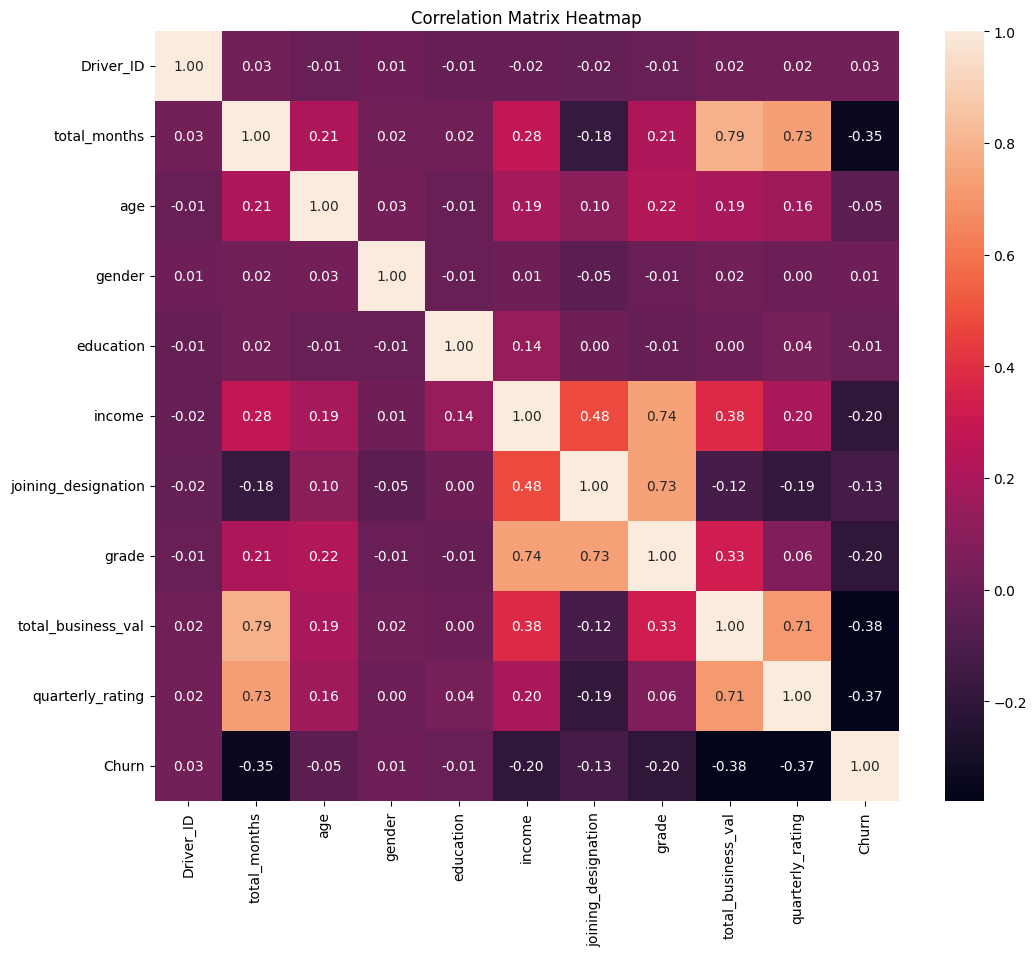

In [40]:
# checking correlation of numerical cols 
plt.figure(figsize=(12,10))
corr_matrix=dfg[continuous_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [41]:
# Findinf strong correlations
threshold = 0.7  

strong_positive_corrs = []
strong_negative_corrs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            strong_positive_corrs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
        elif corr_matrix.iloc[i, j] < -threshold:
            strong_negative_corrs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))


print(f"Strong Positive Correlations (threshold > {threshold}):")
for col1, col2, corr in strong_positive_corrs:
    print(f"{col1} and {col2}: {corr:.2f}")
print(20*"-")
print(f"Strong Negative Correlations (threshold < -{threshold}):")
for col1, col2, corr in strong_negative_corrs:
    print(f"{col1} and {col2}: {corr:.2f}")

Strong Positive Correlations (threshold > 0.7):
grade and income: 0.74
grade and joining_designation: 0.73
total_business_val and total_months: 0.79
quarterly_rating and total_months: 0.73
quarterly_rating and total_business_val: 0.71
--------------------
Strong Negative Correlations (threshold < -0.7):


In [42]:
# let change the threshol and check 
threshold = 0.5  

strong_positive_corrs = []
strong_negative_corrs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            strong_positive_corrs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
        elif corr_matrix.iloc[i, j] < -threshold:
            strong_negative_corrs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))


print(f"Strong Positive Correlations (threshold > {threshold}):")
for col1, col2, corr in strong_positive_corrs:
    print(f"{col1} and {col2}: {corr:.2f}")
print(20*"-")
print(f"Strong Negative Correlations (threshold < -{threshold}):")
for col1, col2, corr in strong_negative_corrs:
    print(f"{col1} and {col2}: {corr:.2f}")

Strong Positive Correlations (threshold > 0.5):
grade and income: 0.74
grade and joining_designation: 0.73
total_business_val and total_months: 0.79
quarterly_rating and total_months: 0.73
quarterly_rating and total_business_val: 0.71
--------------------
Strong Negative Correlations (threshold < -0.5):


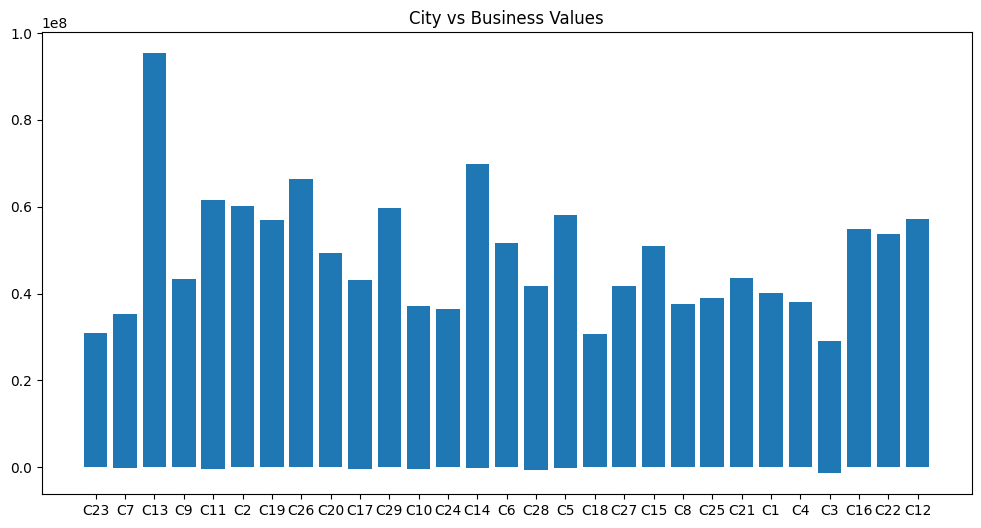

In [43]:
plt.figure(figsize = (12,6))
plt.bar(dfg['city'] , dfg['total_business_val'])
plt.title("City vs Business Values")
plt.show()

> we can see city with citycode : `C13` has the highest business value associated with it.

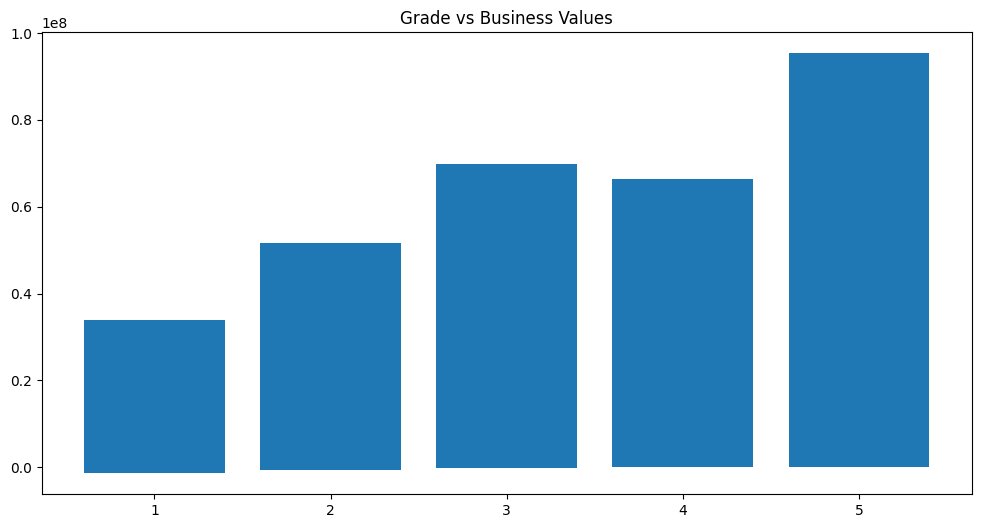

In [44]:
plt.figure(figsize = (12,6))
plt.bar(dfg['grade'] , dfg['total_business_val'])
plt.title("Grade vs Business Values")
plt.show()

> drivers with grade 5 generated highest business values

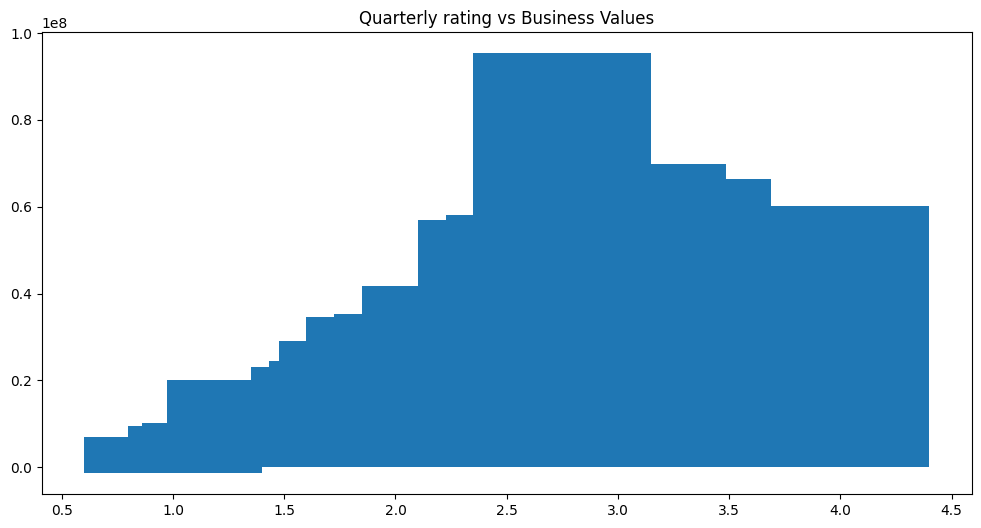

In [45]:
plt.figure(figsize = (12,6))
plt.bar(dfg['quarterly_rating'] , dfg['total_business_val'])
plt.title("Quarterly rating vs Business Values")
plt.show()

> quarterly rating above 2.5 brings the highest business value

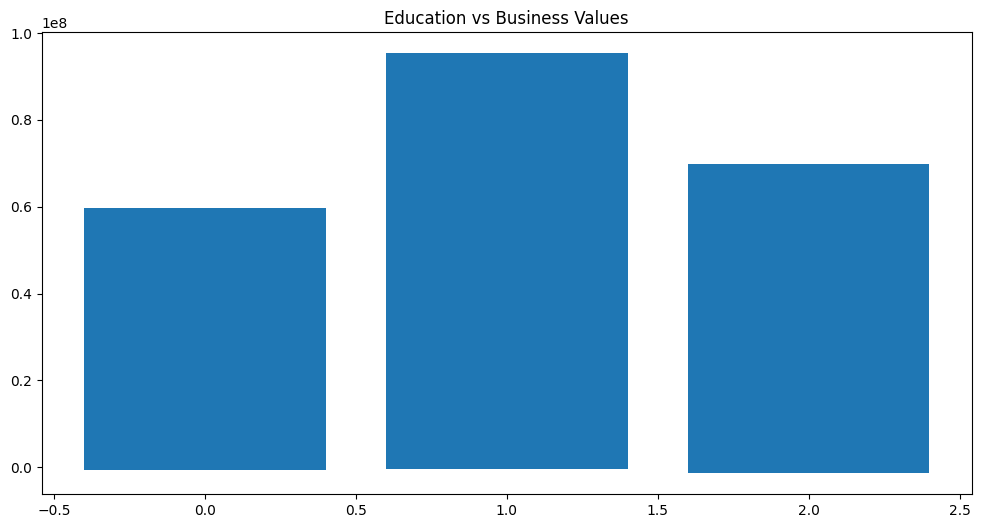

In [46]:
plt.figure(figsize = (12,6))
plt.bar(dfg['education'] , dfg['total_business_val'])
plt.title("Education vs Business Values")
plt.show()

> data shows that drivers with education level : 1 (i.e 12th plus) generates the highest business value followed by education level : 2 (i.e graduate).

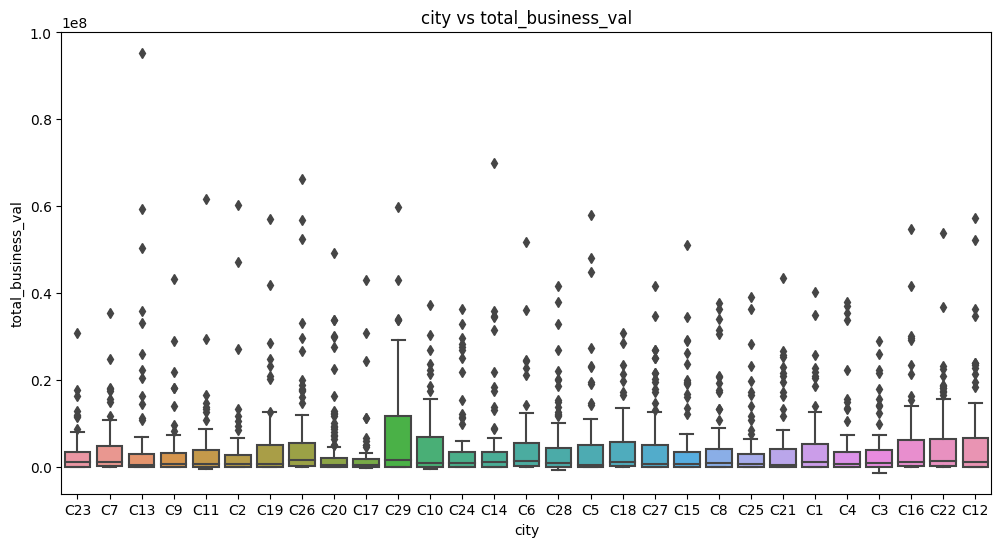

In [47]:
# plotting boxplots for categorical col
cat_col='city'
num_col='total_business_val'
# for col in continuous_cols:
plt.figure(figsize = (12,6))
sns.boxplot(data=dfg,x=cat_col, y=num_col)
plt.title(f"{cat_col} vs {num_col}")
plt.show()

> city with citycode `C13` has the highest outlier in the data

In [51]:
dfg[continuous_cols].dtypes

Driver_ID                       int64
total_months                    int64
age                           float64
gender                        float64
education                       int64
income                          int64
DOJ                    datetime64[ns]
joining_designation             int64
grade                           int64
total_business_val              int64
quarterly_rating              float64
Churn                           int64
dtype: object

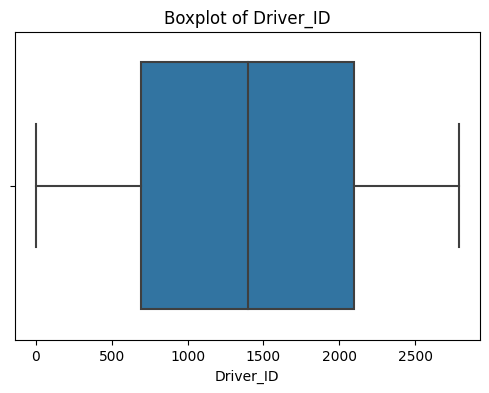

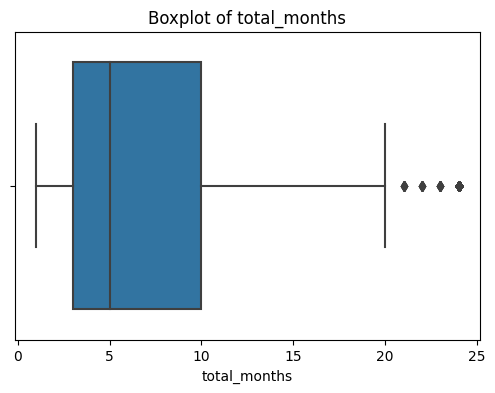

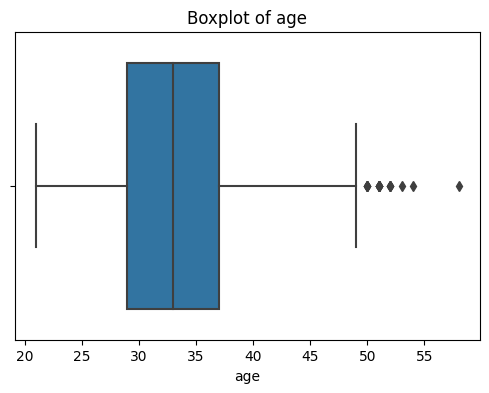

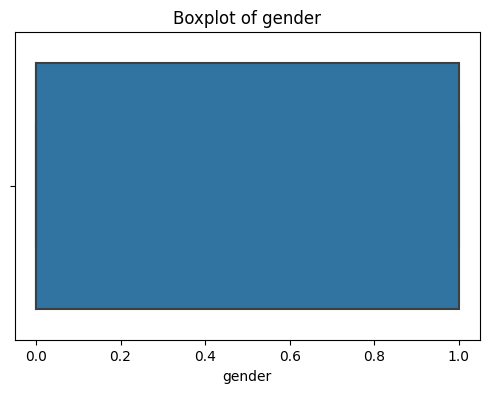

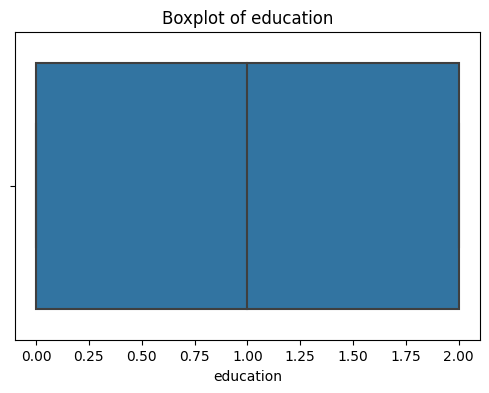

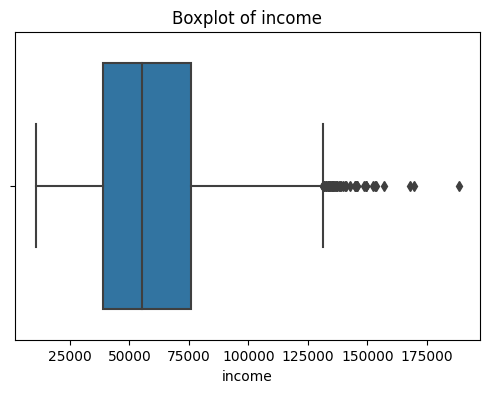

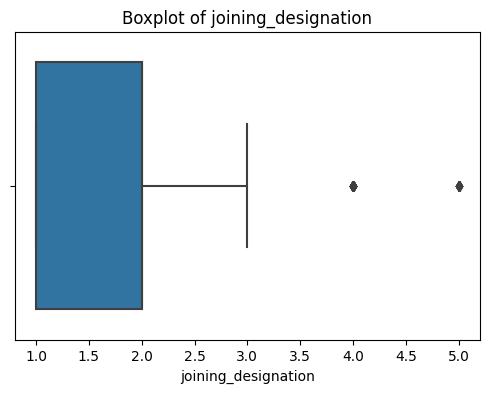

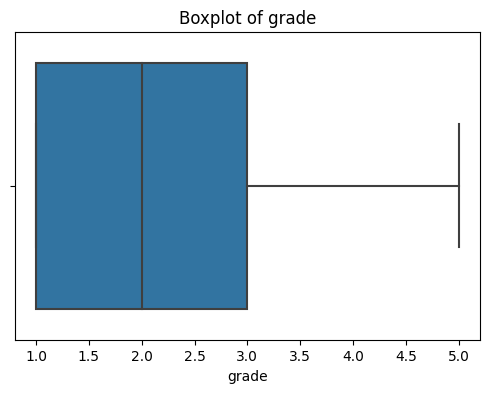

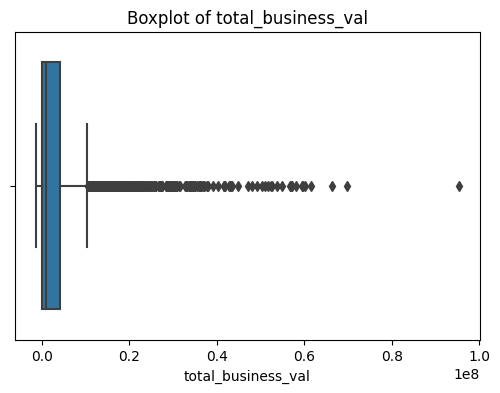

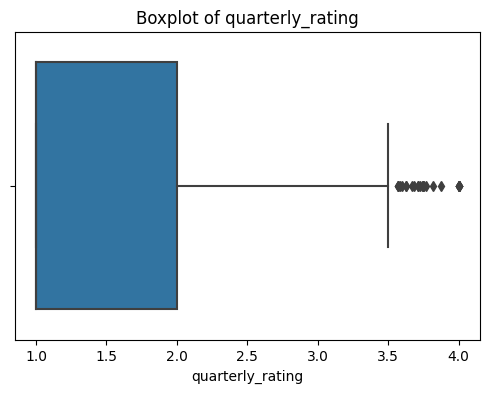

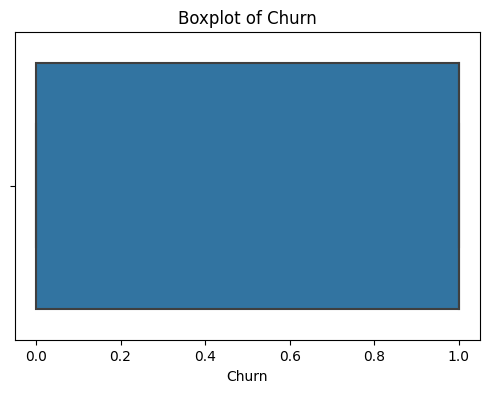

In [52]:
# outlier detection and treatment 
for col in continuous_cols:
    if col!= "DOJ":
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=dfg[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

> from visual representation we can see there are columns whcih have outliers.

In [53]:
# treamtment 
# median imputation :  as it preserve the central tendency of the distribution.
# clipping : to limit their impact without distorting the underlying distributions.
# leaving few cols 
def outlier_detection(series):
    q1=series.quantile(0.25)
    q3=series.quantile(0.75)
    iqr=q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr 
    if series.name in ['age' , 'income'] :
        median_value = series.median()
        output=series.apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    else:
        output=series.clip(lower_bound, upper_bound)
    return output

In [54]:
# treatment for cols 
for col in continuous_cols:
    dfg[col] = outlier_detection(dfg[col])

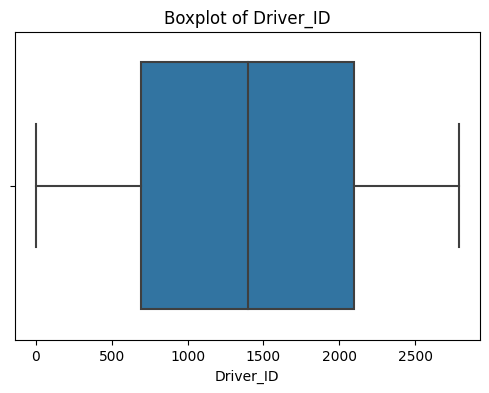

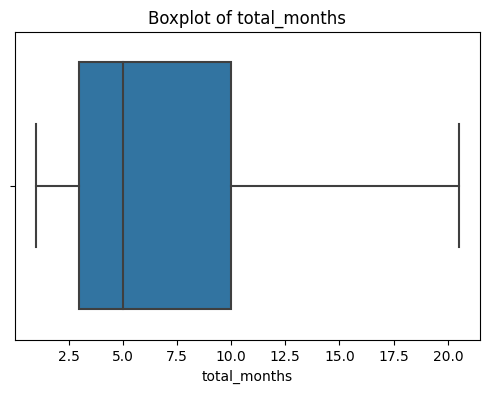

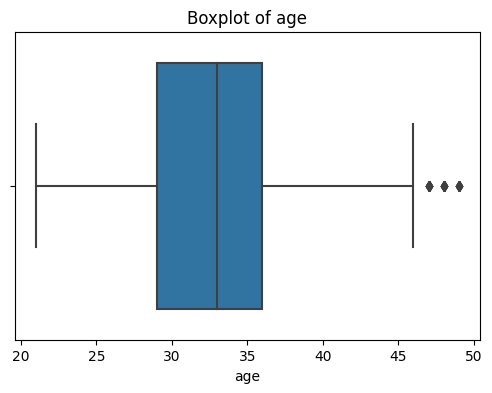

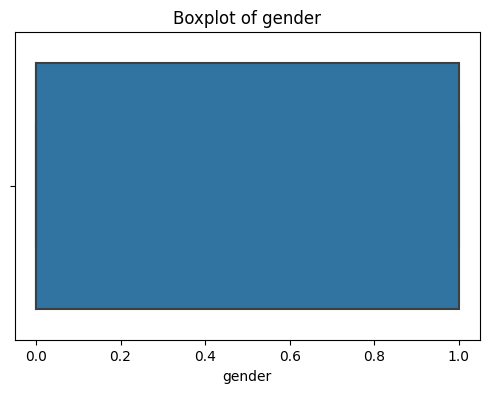

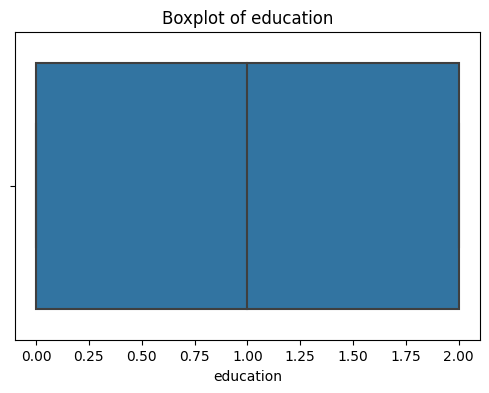

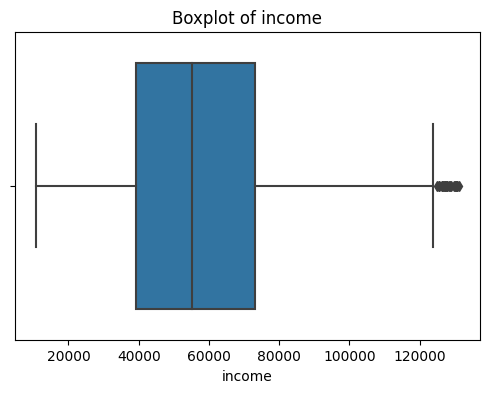

TypeError: Horizontal orientation requires numeric `x` variable.

<Figure size 600x400 with 0 Axes>

In [55]:
# checking putlier treamtment effects 
for col in continuous_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=dfg[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [30]:
# checking skewness of the features 
def check_skewness(series):
    if series.dtype != 'int64' and series.dtype != 'float64':
        return 
    col_skewness = skew(series)
    if col_skewness < -1:
        comment = "Highly left-skewed"
    elif -1 <= col_skewness < -0.5:
        comment = "Moderately left-skewed"
    elif -0.5 <= col_skewness < 0.5:
        comment = "Approximately symmetric"
    elif 0.5 <= col_skewness < 1:
        comment = "Moderately right-skewed"
    else:
        comment = "Highly right-skewed"
    print(f"{series.name}: Skewness = {col_skewness:.2f} ({comment})")

In [31]:
for col in continuous_cols:
    check_skewness(dfg[col])

Driver_ID: Skewness = -0.00 (Approximately symmetric)
total_months: Skewness = 1.06 (Highly right-skewed)
age: Skewness = 0.37 (Approximately symmetric)
gender: Skewness = 0.36 (Approximately symmetric)
education: Skewness = -0.01 (Approximately symmetric)
income: Skewness = 0.55 (Moderately right-skewed)
joining_designation: Skewness = 0.44 (Approximately symmetric)
grade: Skewness = 0.52 (Moderately right-skewed)
total_business_val: Skewness = 1.21 (Highly right-skewed)
quarterly_rating: Skewness = 1.03 (Highly right-skewed)
Churn: Skewness = -0.77 (Moderately left-skewed)


## Data Preprocessing

In [32]:
# checking duplicate data 
dup = dfg[dfg.duplicated()]
if dup.empty:
    print("No duplicate records found.")
else:
    print("Duplicate records found:")
    print(dup)

No duplicate records found.


In [33]:
# missing value detection and treatment 
dfg.isna().sum()

Driver_ID              0
total_months           0
age                    0
gender                 0
city                   0
education              0
income                 0
DOJ                    0
joining_designation    0
grade                  0
total_business_val     0
quarterly_rating       0
Churn                  0
dtype: int64

In [34]:
# feature engineering 
dfg.head()

,Driver_ID,total_months,age,gender,city,education,income,DOJ,joining_designation,grade,total_business_val,quarterly_rating,Churn
0,1,3.0,28.0,0.0,C23,2,57387.0,2018-12-24,1.0,1,1715580,2.0,1
1,2,2.0,31.0,0.0,C7,2,67016.0,2020-11-06,2.0,2,0,1.0,0
2,4,5.0,43.0,0.0,C13,2,65603.0,2019-12-07,2.0,2,350000,1.0,1
3,5,3.0,29.0,0.0,C9,0,46368.0,2019-01-09,1.0,1,120360,1.0,1
4,6,5.0,31.0,1.0,C11,1,78728.0,2020-07-31,3.0,3,1265000,1.6,0


In [56]:
# creating date related fields 
dfg['year']=dfg['DOJ'].dt.year
dfg['month']=dfg['DOJ'].dt.month
dfg['day']=dfg['DOJ'].dt.day
dfg.drop(columns='DOJ',inplace=True)

In [57]:
# # creating bins for ages
# print(f"min age : {dfg['age'].min()} \nmax age : {dfg['age'].max()}")

# dfg['age']=pd.cut(dfg['age'] , bins = 5 , labels=['a','b','c','d','e'])

In [58]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [59]:
# new feature wrt quarterly rating increase 
first_quar=df.groupby(['Driver_ID']).agg({'Quarterly Rating' : "first"})
last_quar = df.groupby(['Driver_ID']).agg({'Quarterly Rating' : "last"})

rating_change = (last_quar['Quarterly Rating'] > first_quar['Quarterly Rating']).reset_index()
rating_change['Quarterly Rating']=rating_change['Quarterly Rating'].astype(int)

dfg['quarterly_rating_increased']=rating_change['Quarterly Rating']


In [60]:
# new feature wrt income increase 
first_income=df.groupby(['Driver_ID']).agg({'Income' : "first"})
last_income = df.groupby(['Driver_ID']).agg({'Income' : "last"})

income_change = (last_income['Income'] > first_income['Income']).reset_index()
income_change['Income']=income_change['Income'].astype(int)

dfg['income_increased']=income_change['Income']

In [61]:
dfg.head()

,Driver_ID,total_months,age,gender,city,education,income,joining_designation,grade,total_business_val,quarterly_rating,Churn,year,month,day,quarterly_rating_increased,income_increased
0,1,3.0,28.0,0.0,C23,2,57387.0,1.0,1,1715580.0,2.0,1,2018,12,24,0,0
1,2,2.0,31.0,0.0,C7,2,67016.0,2.0,2,0.0,1.0,0,2020,11,6,0,0
2,4,5.0,43.0,0.0,C13,2,65603.0,2.0,2,350000.0,1.0,1,2019,12,7,0,0
3,5,3.0,29.0,0.0,C9,0,46368.0,1.0,1,120360.0,1.0,1,2019,1,9,0,0
4,6,5.0,31.0,1.0,C11,1,78728.0,3.0,3,1265000.0,1.6,0,2020,7,31,1,0


## Model building

In [62]:
X = dfg.drop(columns='Churn')
y = dfg['Churn']

In [71]:
# splitting the data 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
train,test=train_test_split(dfg, test_size=0.2,random_state=42, stratify=y)

In [72]:
X_train.head()

,Driver_ID,total_months,age,gender,city,education,income,joining_designation,grade,total_business_val,quarterly_rating,year,month,day,quarterly_rating_increased,income_increased
2242,2627,2.0,34.0,1.0,C7,0,104058.0,3.0,3,0.0,1.0,2020,11,6,0,0
1474,1730,1.0,42.0,0.0,C9,0,51579.0,1.0,1,0.0,1.0,2018,5,26,0,0
2132,2499,3.0,27.0,0.0,C17,1,75458.0,2.0,2,0.0,1.0,2019,7,6,0,0
1873,2200,20.5,34.0,0.0,C15,1,69756.0,1.0,3,10434125.0,3.0,2016,6,21,1,0
462,539,1.0,36.0,0.0,C24,0,109296.0,2.0,3,0.0,1.0,2016,6,20,0,0


In [73]:
X_train.shape

(1904, 16)

In [74]:
train.shape

(1904, 17)

In [75]:
train.to_csv("../artifact/train.csv")
test.to_csv("../artifact/test.csv")

In [76]:
#encoding 
te_cols = ["city"]

te = TargetEncoder() 
X_train[te_cols]=te.fit_transform(X_train[te_cols],y_train)
X_test[te_cols]=te.transform(X_test[te_cols])

e:\Projects\DriverChurn Predictor\.env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\Projects\DriverChurn Predictor\.env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [77]:
X_train.head()

,Driver_ID,total_months,age,gender,city,education,income,joining_designation,grade,total_business_val,quarterly_rating,year,month,day,quarterly_rating_increased,income_increased
2242,2627,2.0,34.0,1.0,0.661017,0,104058.0,3.0,3,0.0,1.0,2020,11,6,0,0
1474,1730,1.0,42.0,0.0,0.687500,0,51579.0,1.0,1,0.0,1.0,2018,5,26,0,0
2132,2499,3.0,27.0,0.0,0.803571,1,75458.0,2.0,2,0.0,1.0,2019,7,6,0,0
1873,2200,20.5,34.0,0.0,0.641026,1,69756.0,1.0,3,10434125.0,3.0,2016,6,21,1,0
462,539,1.0,36.0,0.0,0.685185,0,109296.0,2.0,3,0.0,1.0,2016,6,20,0,0


In [78]:
X_test.head()

,Driver_ID,total_months,age,gender,city,education,income,joining_designation,grade,total_business_val,quarterly_rating,year,month,day,quarterly_rating_increased,income_increased
937,1103,5.0,26.0,0.0,0.712121,2,40318.0,1.0,1,0.0,1.000000,2020,8,7,0,0
765,899,3.0,29.0,0.0,0.752066,0,28565.0,1.0,1,307100.0,1.000000,2018,6,16,0,0
34,46,3.0,36.0,1.0,0.754386,2,42171.0,1.0,1,338290.0,1.000000,2018,10,28,0,0
480,559,5.0,40.0,0.0,0.720588,0,44342.0,1.0,1,1722620.0,2.200000,2020,8,14,1,0
303,358,14.0,39.0,1.0,0.708861,2,117830.0,3.0,3,5175130.0,1.857143,2019,10,29,0,0


In [79]:
# scalling 
se = StandardScaler() 

X_train = se.fit_transform(X_train)
X_test = se.transform(X_test)

In [80]:
# handling imbalanced data 
sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train , y_train)
# X_test_res = sm.resample(X_test)

In [81]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
  
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, the shape of train_X: (1904, 16)
Before OverSampling, the shape of train_y: (1904,) 

Before OverSampling, counts of label '1': 1292
Before OverSampling, counts of label '0': 612


In [82]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (2584, 16)
After OverSampling, the shape of train_y: (2584,) 

After OverSampling, counts of label '1': 1292
After OverSampling, counts of label '0': 1292


#### Model 0 : DecisionTreeClassifier

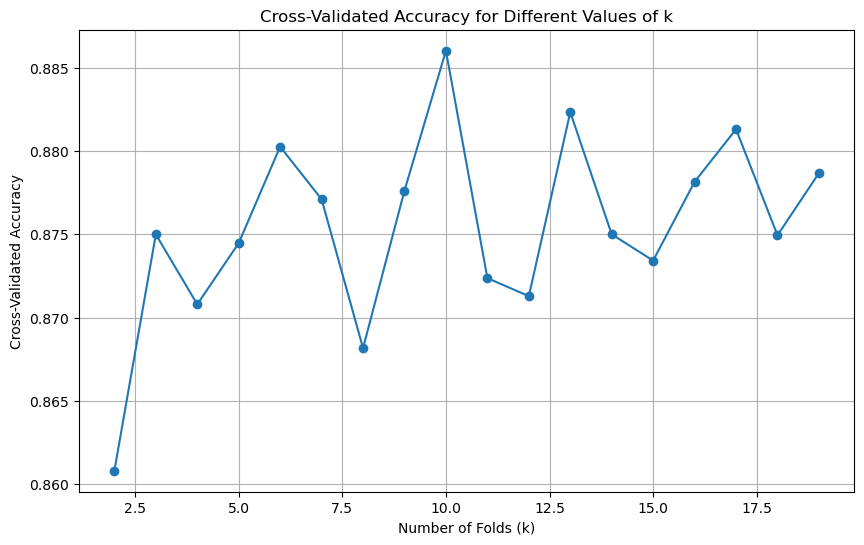

Best value of k: 10 with accuracy: 0.8860


In [52]:
# model initialization : finding the optimal value for k 
model0 = DecisionTreeClassifier(random_state=7)

cv_scores = []
k_values=range(2, 20)
# selecting best value of k 
for k in k_values:
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model0, X_train, y_train,cv=kf)
     cv_scores.append(np.mean(scores))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validated Accuracy for Different Values of k')
plt.grid()
plt.show()

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

In [70]:
# training base model with best_k
kfold = StratifiedKFold(n_splits = best_k)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

dt_clf = DecisionTreeClassifier(random_state=7,class_weight=class_weights_dict)
cv_results_dt = cross_validate(dt_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)


print(f"K-Fold Accuracy Mean: \n Train: {cv_results_dt['train_score'].mean()*100:.2f} \n Validation: {cv_results_dt['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_dt['train_score'].std()*100:.2f}, \n Validation: {cv_results_dt['test_score'].std()*100:.2f}")

K-Fold Accuracy Mean: 
 Train: 100.00 
 Validation: 86.87
K-Fold Accuracy Std: 
 Train: 0.00, 
 Validation: 1.49


In [71]:
# initializing model : selecting best estimators 
# kfold = KFold(n_splits = 10)
params = {
    "max_depth" : [3, 5, 7, 10, 15],
    "max_leaf_nodes" : [20, 40, 60 , 100],
}
grid_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state=7),
                    param_grid= params,
                    scoring = 'accuracy',
                    cv = kfold,
                    n_jobs=-1
                    )

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=7), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15],
                         'max_leaf_nodes': [20, 40, 60, 100]},
             scoring='accuracy')

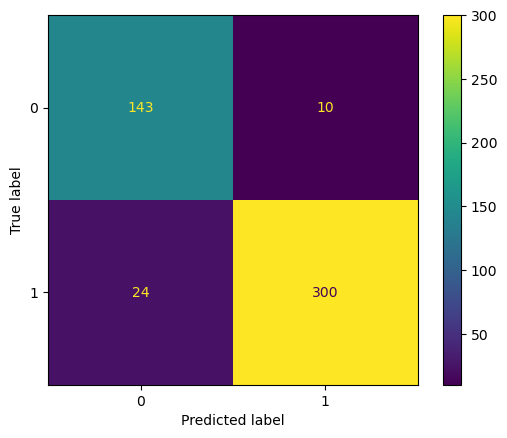

In [72]:
model_dt = grid_dt.best_estimator_
y_pred=  model_dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_dt.classes_)
disp.plot()
plt.show()

In [74]:
dt_report = classification_report(y_test, y_pred, output_dict=True)

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       153
           1       0.97      0.93      0.95       324

    accuracy                           0.93       477
   macro avg       0.91      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477



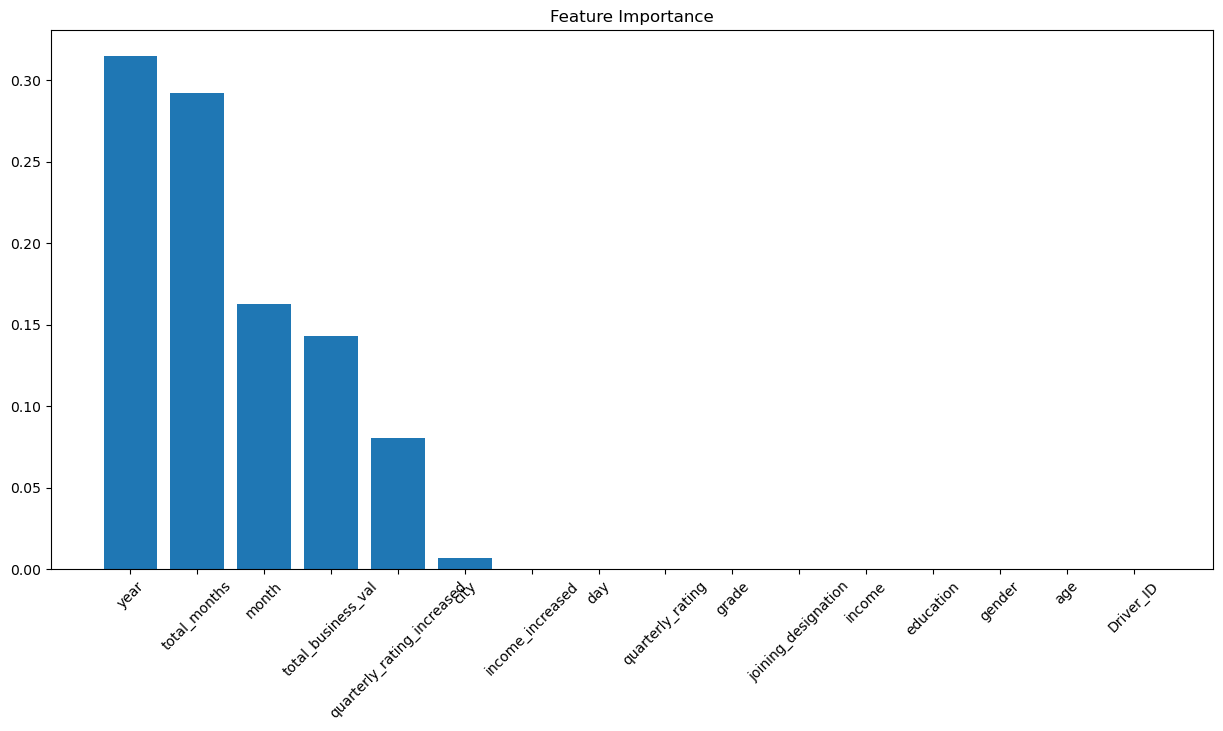

In [76]:
importances = model_dt.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X.columns[i] for i in indices] 


plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=45) 
plt.show()

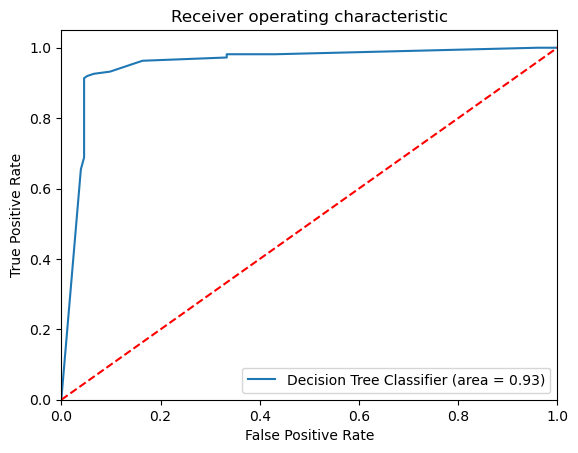

In [77]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,model_dt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Decision Tree Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Model 1 : RandomForestClassifier 

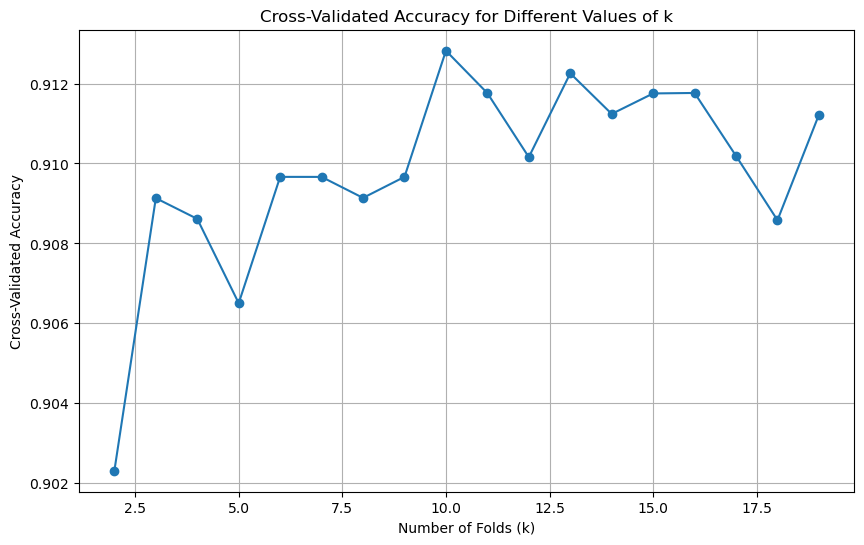

Best value of k: 10 with accuracy: 0.9128


In [53]:
# initialize model : finding best value for k with RF 
model1 = RandomForestClassifier(random_state=7)

cv_scores = []
k_values=range(2, 20)
# selecting best value of k 
for k in k_values:
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model1, X_train, y_train,cv=kf)
     cv_scores.append(np.mean(scores))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validated Accuracy for Different Values of k')
plt.grid()
plt.show()

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

In [54]:
best_k

10

In [65]:
# initialize model : model with defined classs_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

kfold = StratifiedKFold(n_splits=best_k)

rf_clf = RandomForestClassifier(random_state=7, class_weight=class_weights_dict)
# rf_clf = RandomForestClassifier(random_state=7)
cv_results_rf = cross_validate(rf_clf, X_train, y_train, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf['train_score'].std()*100:.2f}, \n Validation: {cv_results_rf['test_score'].std()*100:.2f}")


K-Fold Accuracy Mean: 
 Train: 100.00 
 Validation: 90.86
K-Fold Accuracy Std: 
 Train: 0.00, 
 Validation: 1.62


In [66]:
# initialize model : selecting best estimators 
params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [None,3,5,10],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [8,9,10]
         }
grid_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=7, class_weight=class_weights_dict),
                    param_grid = params,
                    scoring = 'accuracy',
                    cv = kfold ,
                    n_jobs=-1
                    )
# grid_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=7),
#                     param_grid = params,
#                     scoring = 'accuracy',
#                     cv = kfold ,
#                     n_jobs=-1
#                     )

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight={0: 1.5555555555555556,
                                                            1: 0.7368421052631579},
                                              random_state=7),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10],
                         'max_features': [8, 9, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [67]:
print("Best params: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)

Best params:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'n_estimators': 400}
Best score:  0.9217360154312482


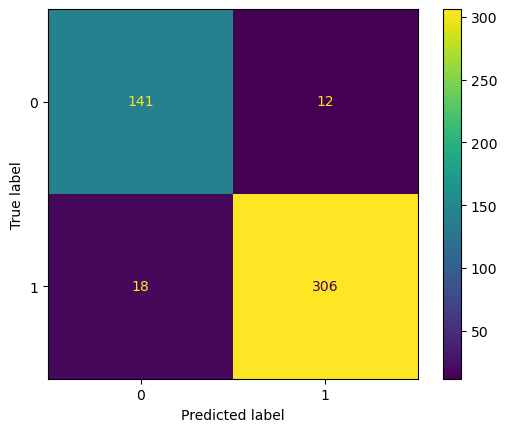

In [68]:
model_rf1 = grid_rf.best_estimator_
y_pred=  model_rf1.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_rf1.classes_)
disp.plot()
plt.show()

In [69]:
rf_model1=classification_report(y_test, y_pred,output_dict=True)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       153
           1       0.96      0.94      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477



In [71]:
rf_model1

{'0': {'precision': 0.8867924528301887,
  'recall': 0.9215686274509803,
  'f1-score': 0.9038461538461539,
  'support': 153.0},
 '1': {'precision': 0.9622641509433962,
  'recall': 0.9444444444444444,
  'f1-score': 0.9532710280373832,
  'support': 324.0},
 'accuracy': 0.9371069182389937,
 'macro avg': {'precision': 0.9245283018867925,
  'recall': 0.9330065359477124,
  'f1-score': 0.9285585909417685,
  'support': 477.0},
 'weighted avg': {'precision': 0.9380562477750088,
  'recall': 0.9371069182389937,
  'f1-score': 0.9374177665043474,
  'support': 477.0}}

In [64]:
rf_model1 # without class weights 

{'0': {'precision': 0.8961038961038961,
  'recall': 0.9019607843137255,
  'f1-score': 0.8990228013029316,
  'support': 153.0},
 '1': {'precision': 0.9535603715170279,
  'recall': 0.9506172839506173,
  'f1-score': 0.9520865533230294,
  'support': 324.0},
 'accuracy': 0.9350104821802935,
 'macro avg': {'precision': 0.9248321338104619,
  'recall': 0.9262890341321715,
  'f1-score': 0.9255546773129805,
  'support': 477.0},
 'weighted avg': {'precision': 0.9351309360071554,
  'recall': 0.9350104821802935,
  'f1-score': 0.9350661045618659,
  'support': 477.0}}

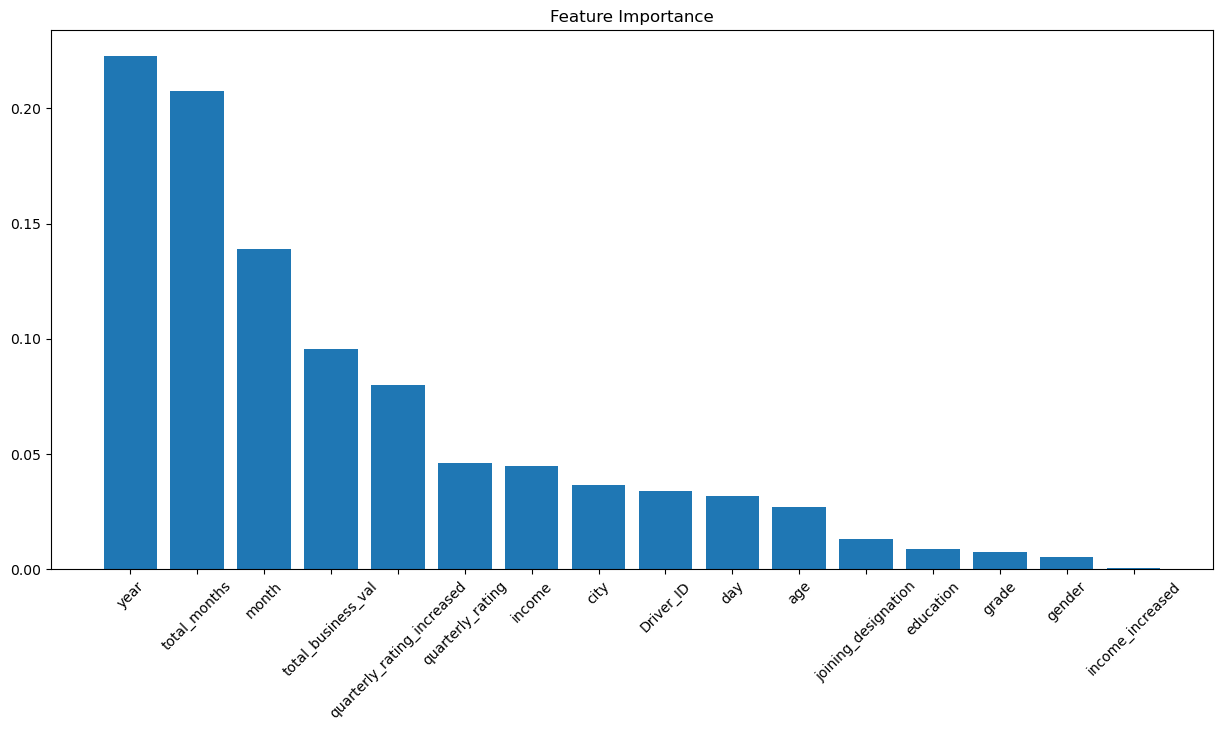

In [62]:
importances = model_rf1.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X.columns[i] for i in indices] 


plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=45) 
plt.show()

In [63]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,model_dt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

NameError: name 'model_dt' is not defined

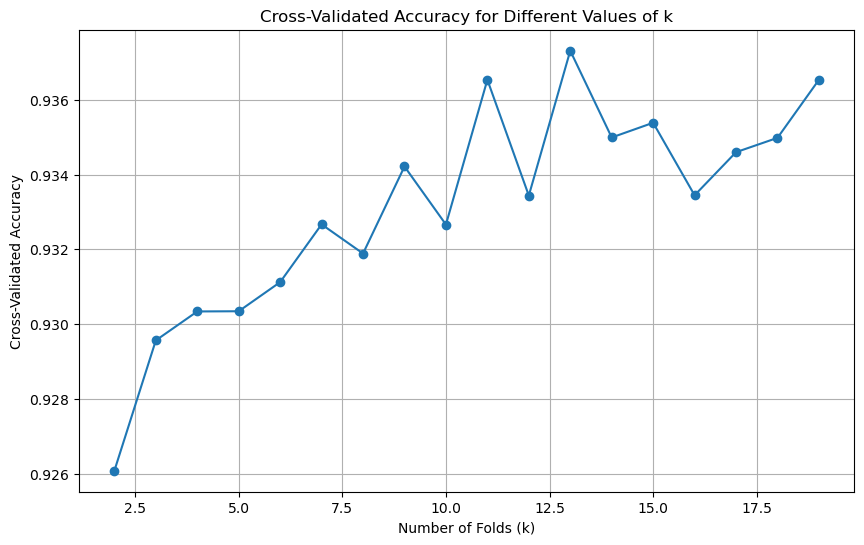

Best value of k: 13 with accuracy: 0.9373


In [91]:
# initialize model : finding optimzal k value with SMOTE data
model2 = RandomForestClassifier(random_state=7)

cv_scores = []
k_values=range(2, 20)
# selecting best value of k 
for k in k_values:
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model2, X_train_res, y_train_res,cv=kf)
     cv_scores.append(np.mean(scores))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validated Accuracy for Different Values of k')
plt.grid()
plt.show()

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")


In [92]:
# initialize model : training base model with SMOTE data 
kfold = StratifiedKFold(n_splits=best_k)

rf_clf2 = RandomForestClassifier(random_state=7)
cv_results_rf2 = cross_validate(rf_clf, X_train_res, y_train_res, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf2['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf2['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf2['train_score'].std()*100:.2f}, \n Validation: {cv_results_rf2['test_score'].std()*100:.2f}")

K-Fold Accuracy Mean: 
 Train: 100.00 
 Validation: 93.54
K-Fold Accuracy Std: 
 Train: 0.00, 
 Validation: 2.33


In [94]:
# selecting best estimators 
params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [3,5,10],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [8,9,10]
         }
grid_rf2 = GridSearchCV(estimator = RandomForestClassifier(random_state=7),
                    param_grid = params,
                    scoring = 'accuracy',
                    cv = kfold,
                    n_jobs=-1
                    )

grid_rf2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=13, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10], 'max_features': [8, 9, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [95]:
print("Best params: ", grid_rf2.best_params_)
print("Best score: ", grid_rf2.best_score_)

Best params:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 8, 'n_estimators': 300}
Best score:  0.9238331792147838


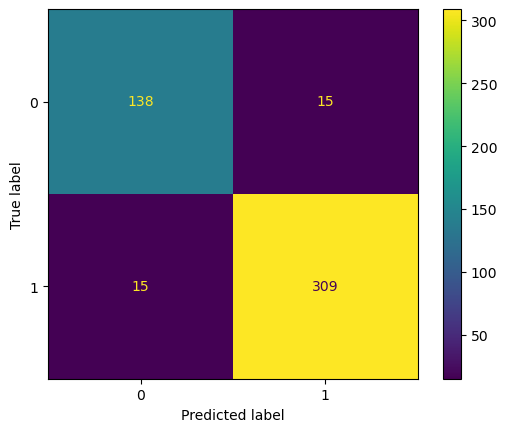

In [96]:
model_rf2 = grid_rf2.best_estimator_
y_pred=  model_rf2.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_rf2.classes_)
disp.plot()
plt.show()

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       153
           1       0.95      0.95      0.95       324

    accuracy                           0.94       477
   macro avg       0.93      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477



In [98]:
rf_model2=classification_report(y_test, y_pred,output_dict=True)

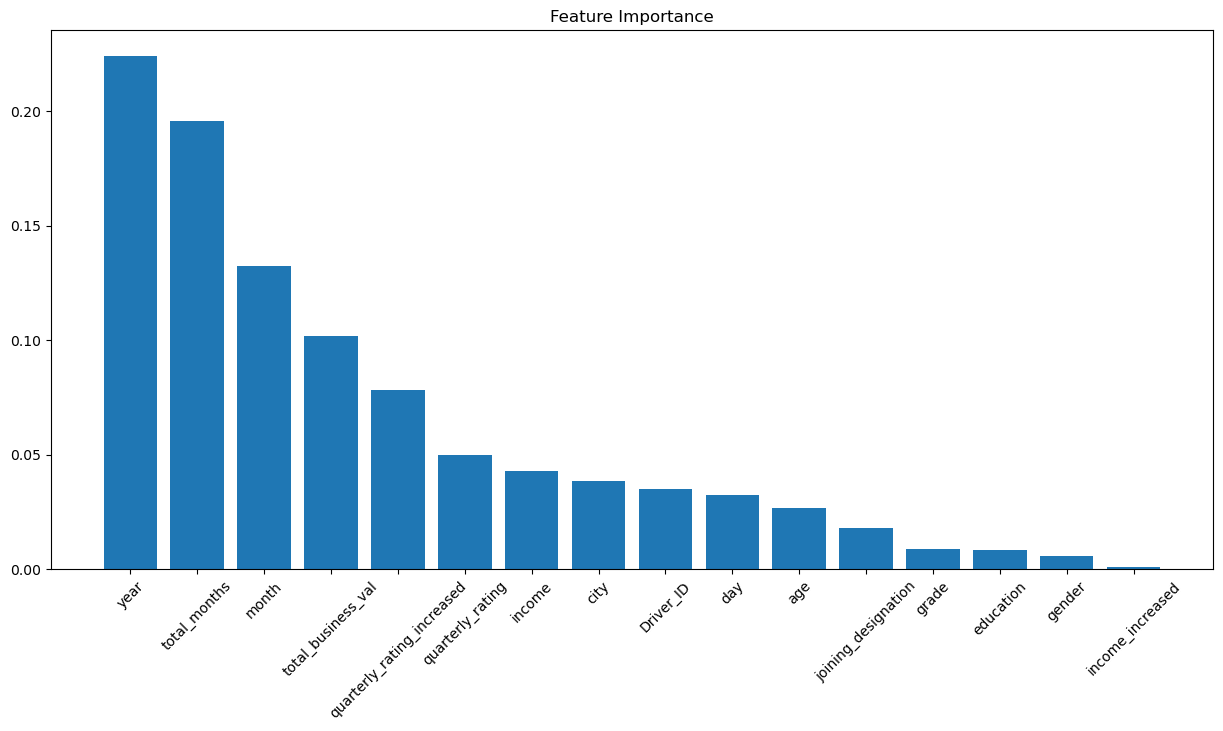

In [99]:
importances = model_rf2.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X.columns[i] for i in indices] 


plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=45) 
plt.show()

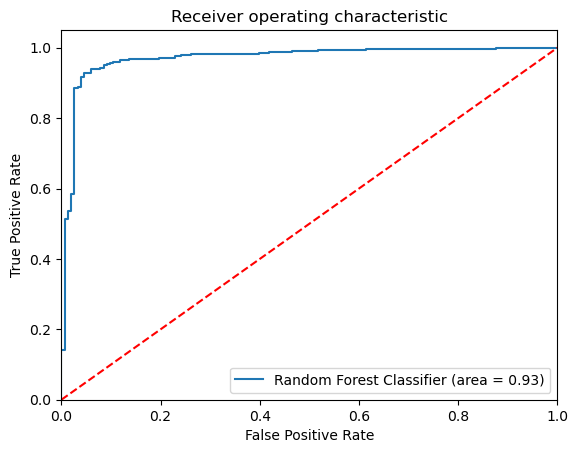

In [100]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,model_rf2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

> model with class_weight and model with SMOTE performs similar

#### Model 2 : GradientBoostingClassifier 

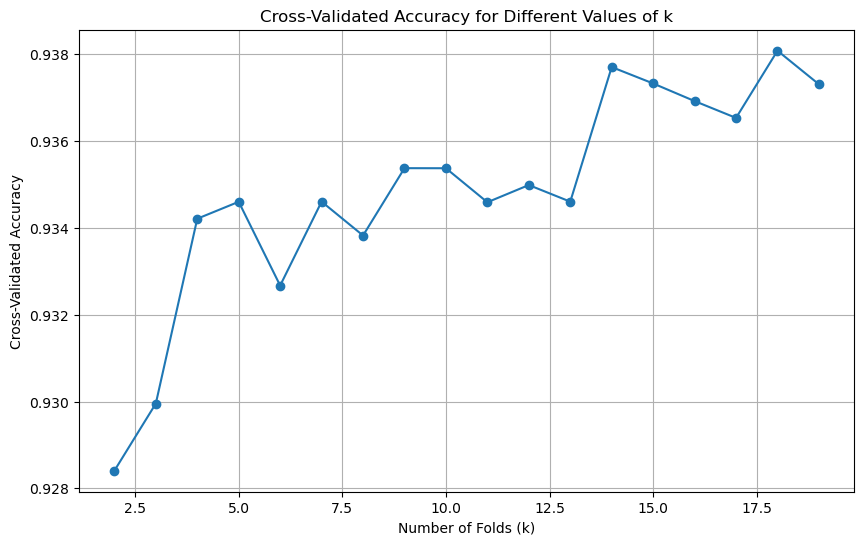

Best value of k: 18 with accuracy: 0.9381


In [101]:
# initialize model : finding best value for k with GBDT
model3 = GradientBoostingClassifier(random_state=7)

cv_scores = []
k_values=range(2, 20)
# selecting best value of k 
for k in k_values:
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model3, X_train_res, y_train_res,cv=kf)
     cv_scores.append(np.mean(scores))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validated Accuracy for Different Values of k')
plt.grid()
plt.show()

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

In [113]:
# training the base model with optimal k 
kfold = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=7)

gbdt_clf = GradientBoostingClassifier(random_state=7)
cv_results_rf = cross_validate(gbdt_clf, X_train_res, y_train_res, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf['train_score'].std()*100:.2f} \n Validation: {cv_results_rf['test_score'].std()*100:.2f}")


K-Fold Accuracy Mean: 
 Train: 95.76 
 Validation: 93.65
K-Fold Accuracy Std: 
 Train: 0.17 
 Validation: 2.38


In [104]:
# selecting best params for the estimator 
params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_features': [8, 9, 10]
}

grid_gbdt = GridSearchCV(estimator=GradientBoostingClassifier(random_state=7),
                       param_grid=params,
                       scoring='accuracy',
                       cv=kfold,
                       n_jobs=-1)

grid_gbdt.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=18, random_state=7, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=7), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10], 'max_features': [8, 9, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [105]:
print("Best params: ", grid_gbdt.best_params_)
print("Best score: ", grid_gbdt.best_score_)

Best params:  {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 9, 'n_estimators': 200}
Best score:  0.9233003893381251


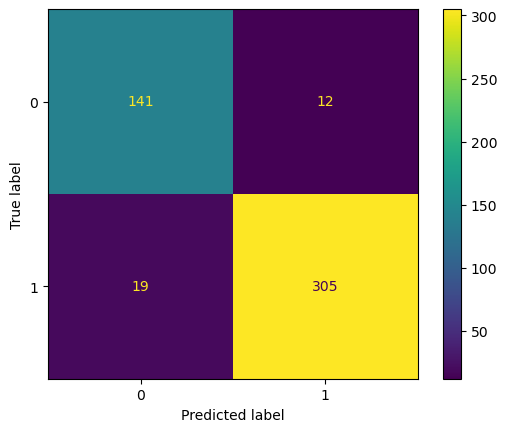

In [106]:
model_gbdt = grid_gbdt.best_estimator_
y_pred=  model_gbdt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_rf2.classes_)
disp.plot()
plt.show()

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       153
           1       0.96      0.94      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477



In [109]:
gbdt_model=classification_report(y_test, y_pred,output_dict=True)

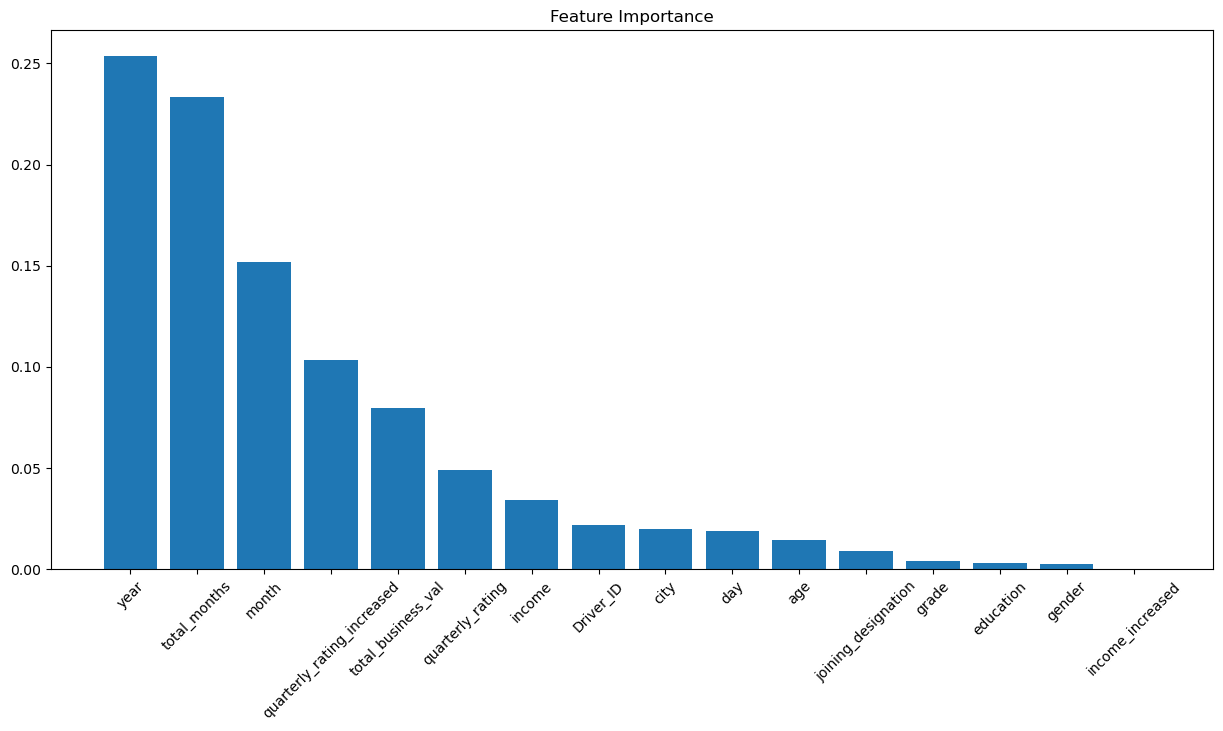

In [110]:
importances = model_gbdt.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X.columns[i] for i in indices] 


plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=45) 
plt.show()

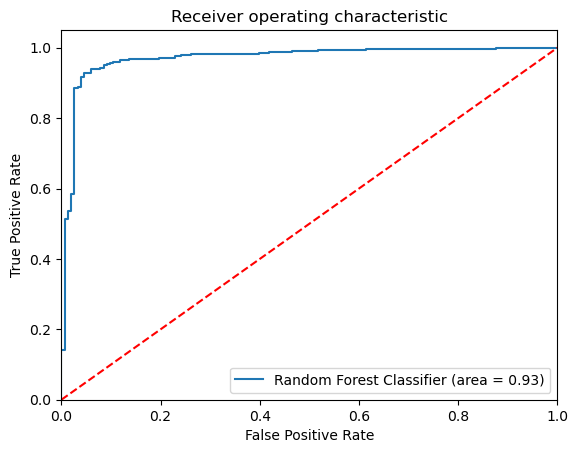

In [111]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,model_rf2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Model 3 : XGBoost 

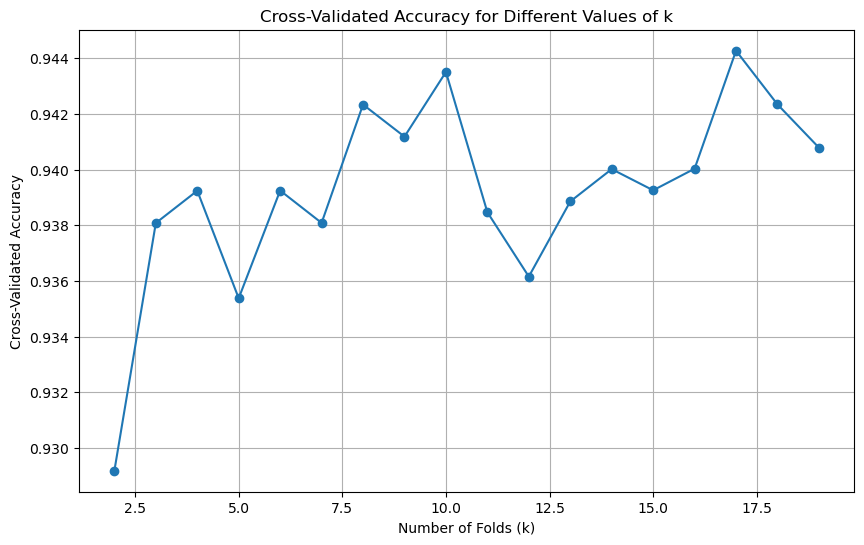

Best value of k: 17 with accuracy: 0.9443


In [112]:
# initialize model : finding best value for k with GBDT
model4 = XGBClassifier(random_state=7)

cv_scores = []
k_values=range(2, 20)
# selecting best value of k 
for k in k_values:
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model4, X_train_res, y_train_res,cv=kf)
     cv_scores.append(np.mean(scores))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validated Accuracy for Different Values of k')
plt.grid()
plt.show()

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

In [123]:
# training the base model with optimal k 
kfold = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=7)

xgb_clf = XGBClassifier(random_state=7)
cv_results_rf = cross_validate(xgb_clf , X_train_res, y_train_res, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf['train_score'].std()*100:.2f} \n Validation: {cv_results_rf['test_score'].std()*100:.2f}")

K-Fold Accuracy Mean: 
 Train: 100.00 
 Validation: 94.43
K-Fold Accuracy Std: 
 Train: 0.00 
 Validation: 2.20


In [116]:
# selecting best params for the estimator 
params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]

}

grid_xgb = GridSearchCV(estimator=XGBClassifier(random_state=7),
                       param_grid=params,
                       scoring='accuracy',
                       cv=kfold,
                       n_jobs=-1)

grid_xgb.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=17, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=7, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 300, 400],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [1, 1.5, 2]},
             scoring='accuracy')

In [117]:
print("Best params: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best params:  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.5}
Best score:  0.928046218487395


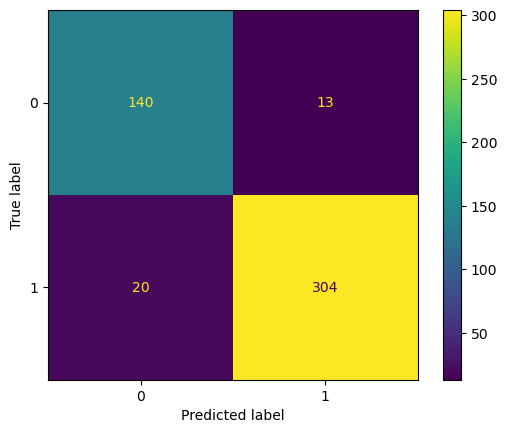

In [128]:
model_xgb = grid_xgb.best_estimator_
y_pred=  model_xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_xgb.classes_)
disp.plot()
plt.show()

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.89       153
           1       0.96      0.94      0.95       324

    accuracy                           0.93       477
   macro avg       0.92      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477



In [130]:
xbg_model=classification_report(y_test, y_pred,output_dict=True)

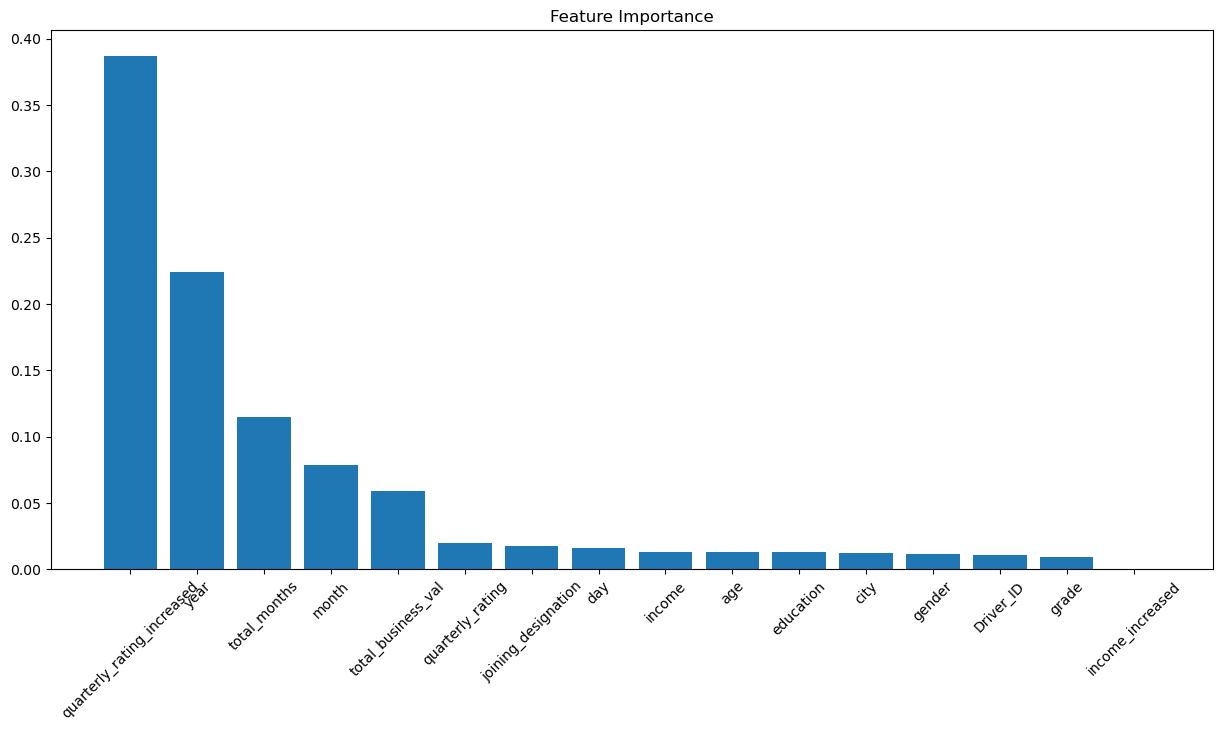

In [131]:
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X.columns[i] for i in indices] 


plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=45) 
plt.show()

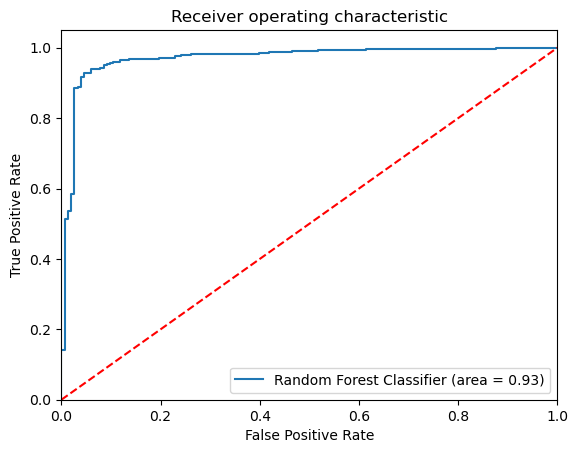

In [132]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,model_rf2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Model 4 : LightGBM

[LightGBM] [Info] Number of positive: 646, number of negative: 646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 1292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 646, number of negative: 646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 1292, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.

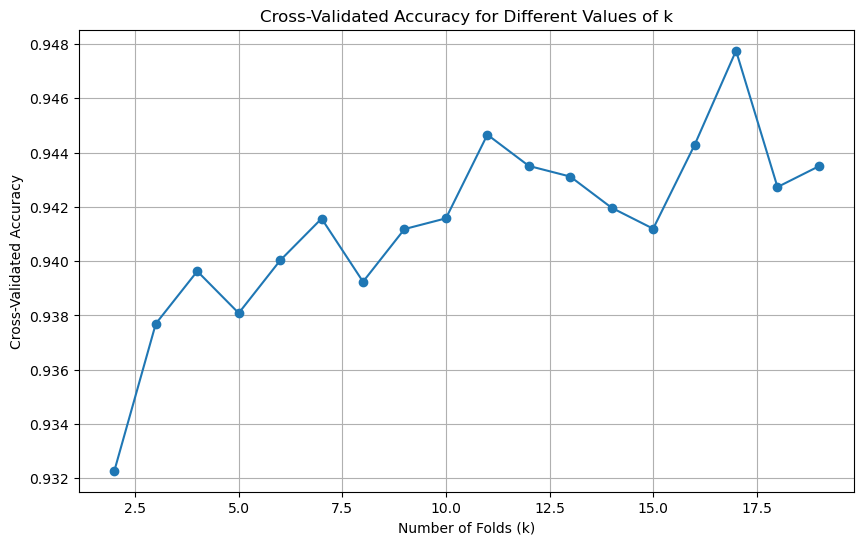

Best value of k: 17 with accuracy: 0.9478


In [124]:
# initialize model : finding best value for k with GBDT
model5 = LGBMClassifier(random_state=7)

cv_scores = []
k_values=range(2, 20)
# selecting best value of k 
for k in k_values:
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model5, X_train_res, y_train_res,cv=kf)
     cv_scores.append(np.mean(scores))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validated Accuracy for Different Values of k')
plt.grid()
plt.show()

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

In [125]:
# training the base model with optimal k 
kfold = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=7)

lgbm_clf = LGBMClassifier(random_state=7)
cv_results_rf = cross_validate(lgbm_clf , X_train_res, y_train_res, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf['train_score'].std()*100:.2f} \n Validation: {cv_results_rf['test_score'].std()*100:.2f}")

[LightGBM] [Info] Number of positive: 1216, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 2432, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1216, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2558
[LightGBM] [Info] Number of data points in the train set: 2432, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1216, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

In [127]:
# selecting best params for the estimator 
params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]

}

grid_lgbm = GridSearchCV(estimator=LGBMClassifier(random_state=7),
                       param_grid=params,
                       scoring='accuracy',
                       cv=kfold,
                       n_jobs=-1)

grid_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1292, number of negative: 612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.678571 -> initscore=0.747214
[LightGBM] [Info] Start training from score 0.747214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

GridSearchCV(cv=StratifiedKFold(n_splits=17, random_state=7, shuffle=True),
             estimator=LGBMClassifier(random_state=7), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 300, 400],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [1, 1.5, 2]},
             scoring='accuracy')

In [133]:
print("Best params: ", grid_lgbm.best_params_)
print("Best score: ", grid_lgbm.best_score_)

Best params:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5}
Best score:  0.9243697478991597


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


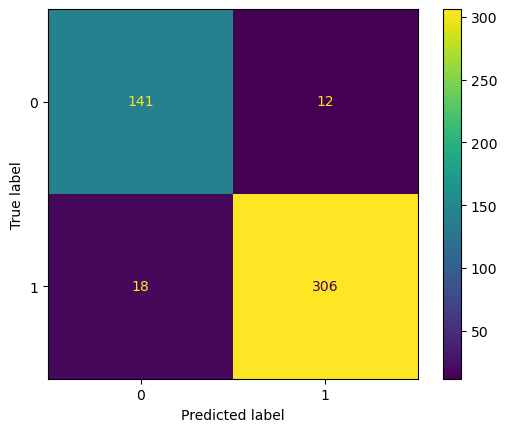

In [134]:
model_lgbm = grid_lgbm.best_estimator_
y_pred=  model_lgbm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_lgbm.classes_)
disp.plot()
plt.show()

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       153
           1       0.96      0.94      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477



In [136]:
lgbm_model=classification_report(y_test, y_pred,output_dict=True)

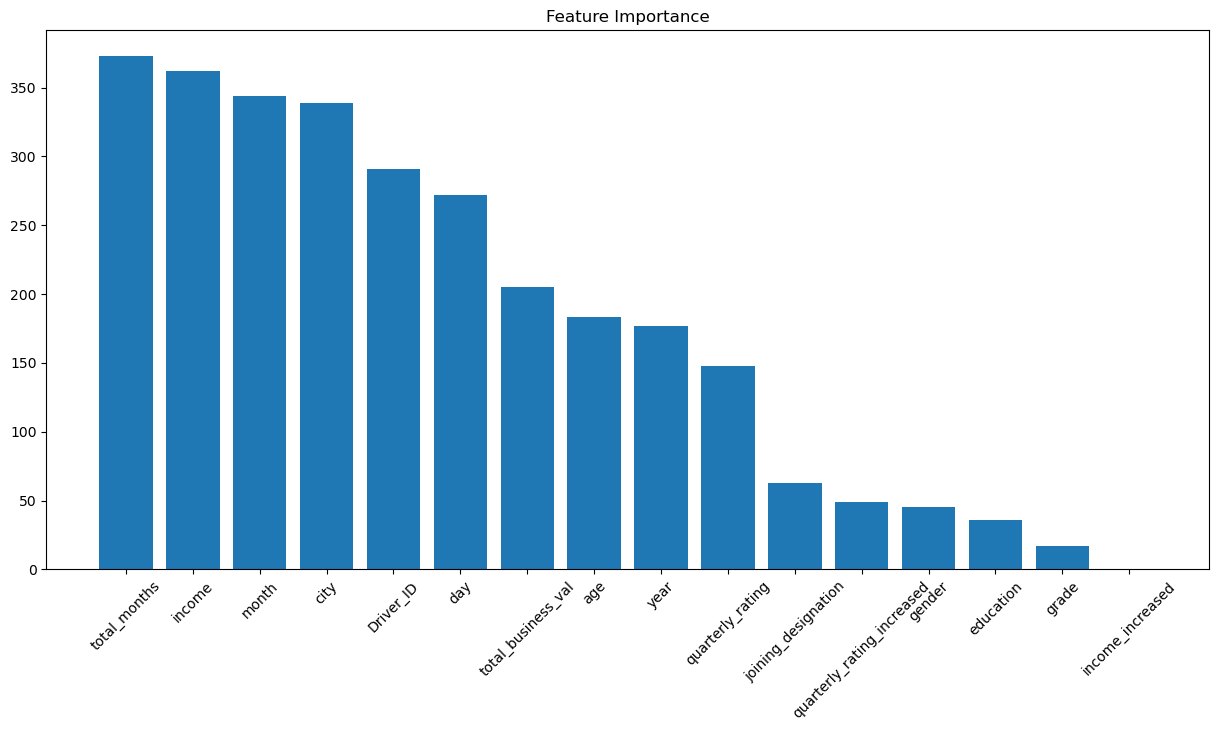

In [137]:
importances = model_lgbm.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X.columns[i] for i in indices] 


plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=45) 
plt.show()

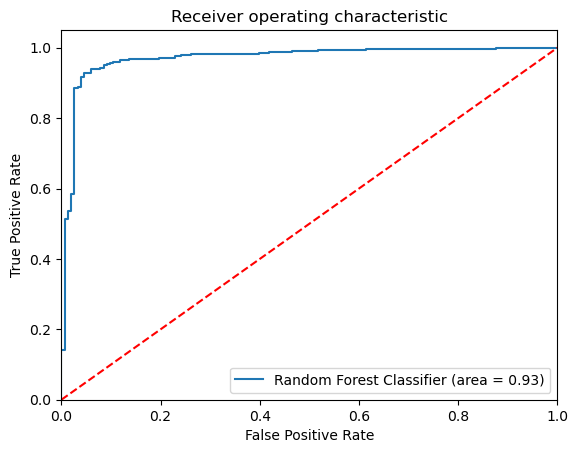

In [138]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,model_rf2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [196]:
# aggregating all the reports in one DF 
reports_df = {}

models =["DecisionTree", "RandomForest1","RandomForest2", "GradientBoosting", "XGBoost", "LightGBM"]
reports =[dt_report, rf_model1,rf_model2,grid_gbdt,xbg_model,lgbm_model]

for model, r in zip(models,reports):
    try:
        print(model) 
        # t=pd.DataFrame(r)
        # t['model']=model
        temp = pd.DataFrame(r).transpose()
        temp['model']=model 
        reports_df[model]=temp
    except:
        continue
    # break
    


DecisionTree
RandomForest1
RandomForest2
GradientBoosting
XGBoost
LightGBM


In [197]:
final_df = pd.concat(reports_df.values()).reset_index() 
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1] 
final_df = final_df[cols]

In [198]:
final_df

,model,index,precision,recall,f1-score,support
0,DecisionTree,0,0.856287,0.934641,0.893750,153.000000
1,DecisionTree,1,0.967742,0.925926,0.946372,324.000000
2,DecisionTree,accuracy,0.928721,0.928721,0.928721,0.928721
3,DecisionTree,macro avg,0.912015,0.930283,0.920061,477.000000
4,DecisionTree,weighted avg,0.931992,0.928721,0.929493,477.000000
5,RandomForest1,0,0.910256,0.928105,0.919094,153.000000
6,RandomForest1,1,0.965732,0.956790,0.961240,324.000000
7,RandomForest1,accuracy,0.947589,0.947589,0.947589,0.947589
8,RandomForest1,macro avg,0.937994,0.942447,0.940167,477.000000
9,RandomForest1,weighted avg,0.947938,0.947589,0.947722,477.000000


#### Model Performance Metrics

**Decision Tree**
- Precision (Class 0): 0.856287
- Recall (Class 0): 0.934641
- F1-score (Class 0): 0.893750
- Precision (Class 1): 0.967742
- Recall (Class 1): 0.925926
- F1-score (Class 1): 0.946372
- Accuracy: 0.928721
- Macro avg Precision: 0.912015
- Macro avg Recall: 0.930283
- Macro avg F1-score: 0.920061
- Weighted avg Precision: 0.931992
- Weighted avg Recall: 0.928721
- Weighted avg F1-score: 0.929493


**Random Forest 1**
- Precision (Class 0): 0.910256
- Recall (Class 0): 0.928105
- F1-score (Class 0): 0.919094
- Precision (Class 1): 0.965732
- Recall (Class 1): 0.956790
- F1-score (Class 1): 0.961240
- Accuracy: 0.947589
- Macro avg Precision: 0.937994
- Macro avg Recall: 0.942447
- Macro avg F1-score: 0.940167
- Weighted avg Precision: 0.947938
- Weighted avg Recall: 0.947589
- Weighted avg F1-score: 0.947817


**Random Forest 2**
- Precision (Class 0): 0.901961
- Recall (Class 0): 0.901961
- F1-score (Class 0): 0.901961
- Precision (Class 1): 0.953704
- Recall (Class 1): 0.953704
- F1-score (Class 1): 0.953704
- Accuracy: 0.937107
- Macro avg Precision: 0.927832
- Macro avg Recall: 0.927832
- Macro avg F1-score: 0.927832
- Weighted avg Precision: 0.937107
- Weighted avg Recall: 0.937107
- Weighted avg F1-score: 0.937107


**XGBoost**
- Precision (Class 0): 0.875000
- Recall (Class 0): 0.915033
- F1-score (Class 0): 0.894584
- Precision (Class 1): 0.958991
- Recall (Class 1): 0.938272
- F1-score (Class 1): 0.948518
- Accuracy: 0.930818
- Macro avg Precision: 0.916995
- Macro avg Recall: 0.926652
- Macro avg F1-score: 0.921451
- Weighted avg Precision: 0.932050
- Weighted avg Recall: 0.930818
- Weighted avg F1-score: 0.931213


**LightGBM**
- Precision (Class 0): 0.886792
- Recall (Class 0): 0.915690
- F1-score (Class 0): 0.900846
- Precision (Class 1): 0.962264
- Recall (Class 1): 0.944444
- F1-score (Class 1): 0.953256
- Accuracy: 0.937107
- Macro avg Precision: 0.924528
- Macro avg Recall: 0.930067
- Macro avg F1-score: 0.927051
- Weighted avg Precision: 0.938056
- Weighted avg Recall: 0.937107
- Weighted avg F1-score: 0.937148

#### Model Selection

For a ride-sharing platform focused on driver churn, the key metric depends on the business objectives:

1. High Recall (Class 1): If the goal is to catch as many potential churners as possible, recall is crucial. Random Forest 1 has the highest recall for Class 1 (0.956790).
2. Balanced Performance (F1-score): The F1-score provides a balance between precision and recall. Random Forest 1 has the highest F1-score for Class 1 (0.961240).
3. Accuracy: Overall performance across all classes can be reflected by accuracy. Random Forest 1 has the highest accuracy (0.947589).
4. Weighted Metrics: Considering the weighted averages of precision, recall, and F1-score gives an overview of the model's performance across all classes. Random Forest 1 performs best with weighted avg F1-score (0.947817).



#### Conclusion
Random Forest 1 stands out as the best model based on these metrics:

- It has the highest recall and F1-score for Class 1, which is important for identifying potential churners.
- It has the highest accuracy and balanced performance across all classes.

## Actionable Insights and Recommendation

- based on the data we saw that ~68% of the drivers have left the company.
- after training the model, best features to represent our data are `months worked in the company`, `total business value generated` , `increase of quarterly rating`, `uareterly ratings` and `monthly average income`.
- comapny needs to employ more insentive or the drivers based on their worked monthsm business value they generate.
- also company can look at doing more frrquent rating of drivers instead of quarterly rating to see how drivers are performing and provide insentives/bonus to top performers.
- Company can also employ a feedback system where drivers can express their intent for leaving, that way company can promptly see what they can do from their based for that particular driver to make him.her stay